In [1]:
import pandas as pd
import numpy as np
# Important Stuff
conc_dict={
    10:1,
    8: .8,
    6: .6,
    5:.5,
    4: .4,
    3:.3,
    2.5:.25,
    2:.2,
    1.25:.125,
    1:.1,
    0:0
}



conccolordict={
    10 :'purple',
    5 : 'mediumblue',
    5: 'royalblue',
    2.5: 'dodgerblue',
    3:'lightskyblue',
    2:'lightblue',
    1.25 :'lightcyan' ,
    0:'gray'
}

colordict = {
    'ER' : 'xkcd:pale purple',
    'DP' : 'xkcd:orange',
    'FP' : 'xkcd:brick red',
    'BH' : 'xkcd:light orange',
    'CA' : 'xkcd:yellow',
    'PC' : 'xkcd:light blue',
    'EL' : 'xkcd:salmon pink',
    'CH' : 'xkcd:peach',
    'BO' : 'xkcd:red',
    'BT' : 'xkcd:green',
    'BU' : 'xkcd:blue green',
    'BV' : 'xkcd:sage',
    'AC' : 'xkcd:blue',
    'CC' : 'xkcd:grey',
    'RI' : 'xkcd:dark blue',
    'DL' : 'xkcd:purple',
    'CG' : 'xkcd:brown',
    'BF' : 'xkcd:lime green',
    'BY' : 'xkcd:periwinkle',
    'PJ' : 'xkcd:sea green',
    'BL' : 'xkcd:olive',
    'BP' : 'xkcd:mauve',
    'BA' : 'xkcd:dark purple',
    'CD' : 'fuchsia',
    'CS' : 'xkcd:red',
    'EH' : 'turquoise',
    'EC' : 'Black',
    'BC' : 'Gray',
    'DF' : 'turquoise',
    'gap': 'white'
}

mediadict = {
'Inulin': 'purple', 'Inulin Mono':'plum', 'Laminarin': 'blue','Laminarin Mono':'lightblue','Xylan':'green','Xylan Mono':'lightgreen','No carb':'black'
}

media_list = ['Inulin','Inulin Mono', 'Laminarin','Laminarin Mono' ,'Xylan','Xylan Mono']

species_list = ['AC', 'EL', 'DP', 'BH', 'PJ', 'DL', 'CS', 'BT', 'BV', 'BP']

concentration_list = [10,5,2.5,1.25]

In [2]:
# ODE
def res_cons(y, t, w, C, m, num_res, num_species):
    
    dydt = np.zeros(num_res + num_species)
    # Constructing the equations for species equations
    for sp_in in range(0, num_species):
        for r_in in range(0, num_res):
            dydt[sp_in] = dydt[sp_in] + w[r_in, sp_in]*C[r_in, sp_in]*y[num_species + r_in]
            # i+r_in denotes the resource equation index
        dydt[sp_in] = y[sp_in]*(dydt[sp_in] - m[sp_in])
        
    # Constructing the equations for resource requations.
    for r_in in range (0, num_res):
        for sp_in in range(0, num_species):
            dydt[r_in + num_species] = dydt[r_in + num_species] + -1*C[r_in, sp_in]*y[r_in + num_species]*y[sp_in]
    return dydt

In [3]:
def get_error(w, C, m, data,media):
    num_errors = 0
    total_MSE = 0 # Initialize Mean Squared Error
    for conc in concentration_list:
        OD, time = getConcData(data, conc,media)

        for rep in list(set(data['Rep'])):
            rep=int(rep)

            w = np.reshape(w, (1, 1))
            C = np.reshape(C, (1, 1))
            m = np.reshape(m, (1))
            init_val = OD[rep][0]
            temp_data = odeint(res_cons, [init_val, conc_dict[conc] + base_med_conc], time[rep], args = (w, C, m, 1, 1))
            temp_error = (temp_data[:, 0] - OD[rep])**2
            num_errors += np.size(OD[rep])
            total_MSE += np.sum(temp_error)
    total_MSE = total_MSE/num_errors
    return total_MSE

In [4]:
# Define objective function
def fun(p, reg_par, data,media):
    
    w = p[0]
    C = p[1]
    m = p[2]
    total_MSE = get_error(w, C, m, data,media)
    total_error = (total_MSE + reg_par*( w**2 + C**2 + m**2)).flatten()[0] # Regularize parameters
        
    return total_error

In [5]:
def getConcData(data, conc, media):
    species_data = data[(data["Concentration"] == conc)]
    reps=list(set(species_data['Rep']))

    # Extract OD and time from the data
    species_data_OD = [[]] * len(reps)
    species_data_t = [[]] * len(reps)
    for rep in list(set(species_data['Rep'])):
        rep=int(rep)

        tmp = species_data[species_data['Rep'] == rep]
        species_data_OD[rep] = np.array(tmp["Blanked OD"]) # Blanked OD
        species_data_t[rep] = np.array(tmp["t"])# Time

        
    return species_data_OD, species_data_t

In [6]:
# Plot data
def plot_tr_data(sol, data, media, species,basemedia):
    w = np.reshape(sol[0], (1, 1))
    C = np.reshape(sol[1], (1, 1))
    m = np.reshape(sol[2], (1))
    run = 0
    plt.figure(figsize = (15, 10))
    for conc in concentration_list:
        OD, time = getConcData(data, conc,media)
        init_val = OD[0][0]
        temp_data = odeint(res_cons, [init_val, conc_dict[conc] + base_med_conc], time[0], args = (w, C, m, 1, 1))

        plt.plot(time[0], temp_data[:, 0], label = str(conc) + " Fitted " + species, color = colordict[species])
        plt.plot(time[0], temp_data[:, 1], label = str(conc) + " " + media, color = mediadict[media])
        for rep in range(2):
            if run < 1:
                plt.plot(time[rep], OD[rep], label = species, color = colordict[species], linestyle = "None", marker = "o")
            else:
                plt.plot(time[rep], OD[rep], color = colordict[species], linestyle = "None", marker = "o")
            run += 1
    plt.legend()
#     plt.savefig('/Users/Erin Ostrem/Documents/Venturelli_Lab/FiberEcology_Manuscript/MCRfits/'+media1+'/'+species1+str(basemedia)+'BaseMedia.png')

    plt.show()
    plt.close()

Parameters:  [3.21572200e-01 1.25000000e+00 2.81403654e-18]
RMSE:  0.003748429967480409


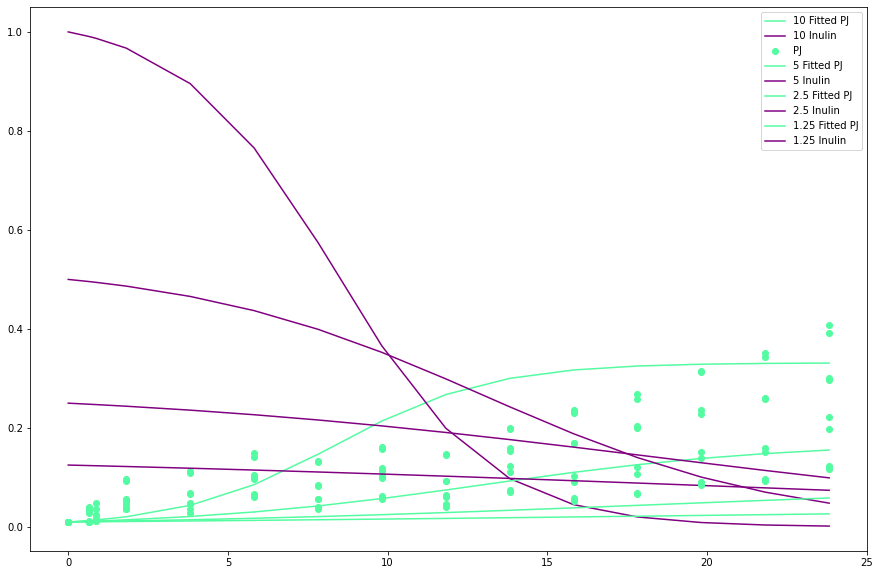

Parameters:  [0.41424233 1.68046704 0.        ]
RMSE:  0.027574976046192586


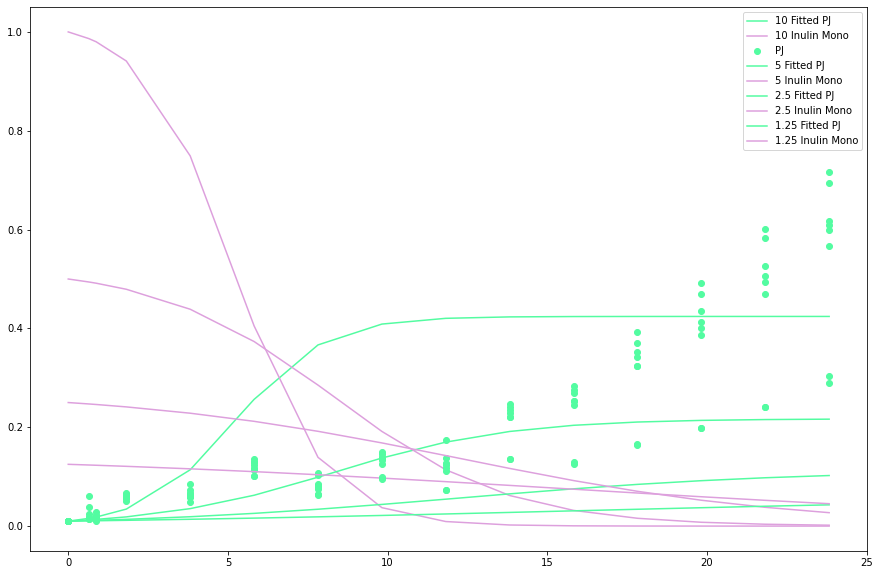

Parameters:  [0.33960333 0.39718991 0.        ]
RMSE:  0.0018205246071161729


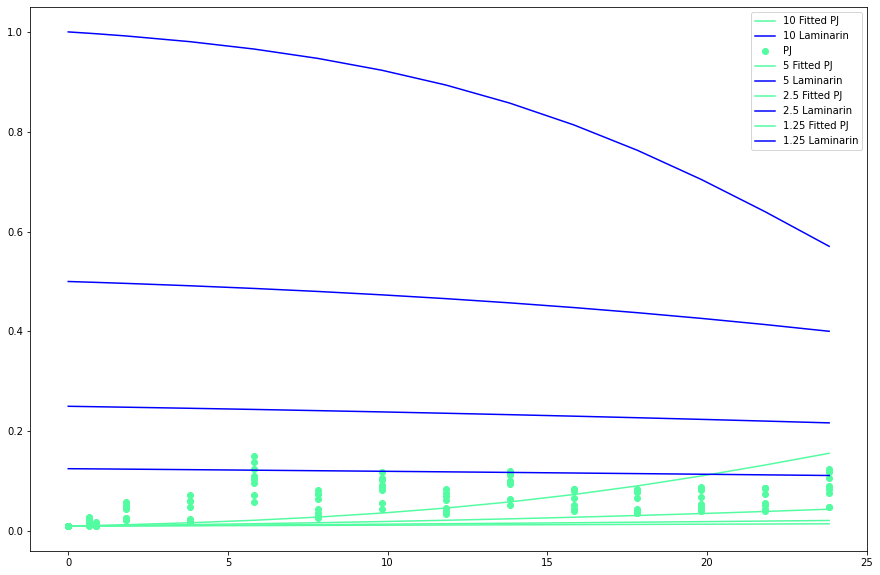

Parameters:  [6.21095700e-01 7.19798952e-01 2.49907357e-17]
RMSE:  0.019327173391040325


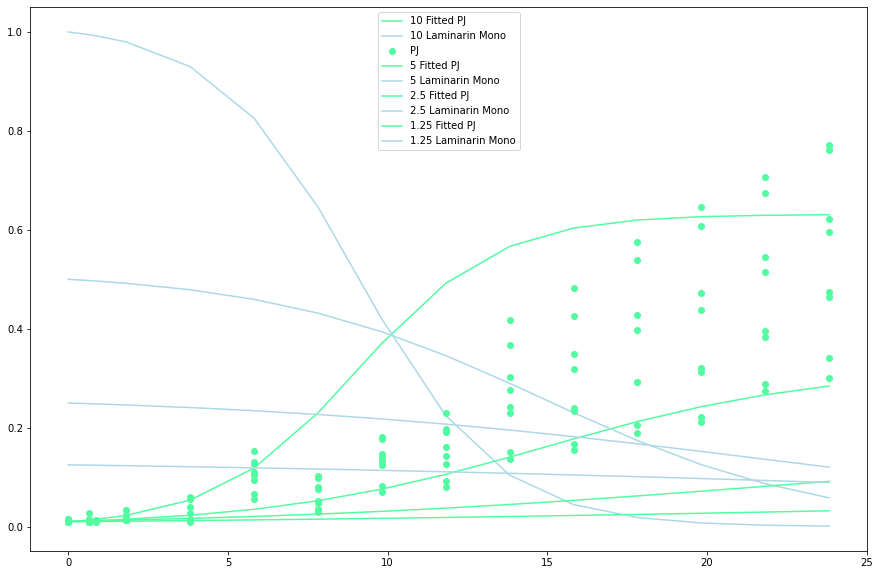

Parameters:  [0.37914678 0.42899653 0.        ]
RMSE:  0.0026898740736449205


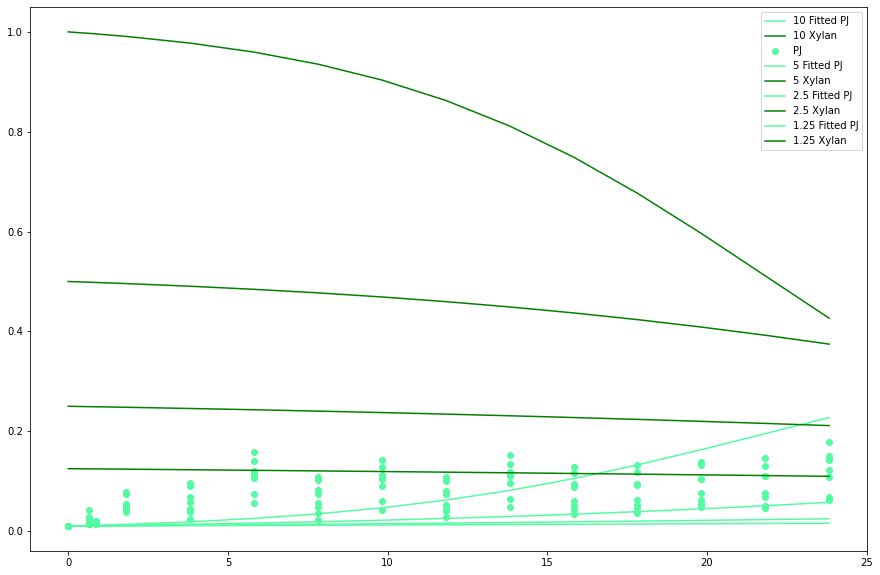

Parameters:  [0.7510239  1.59671467 0.        ]
RMSE:  0.0829647184120463


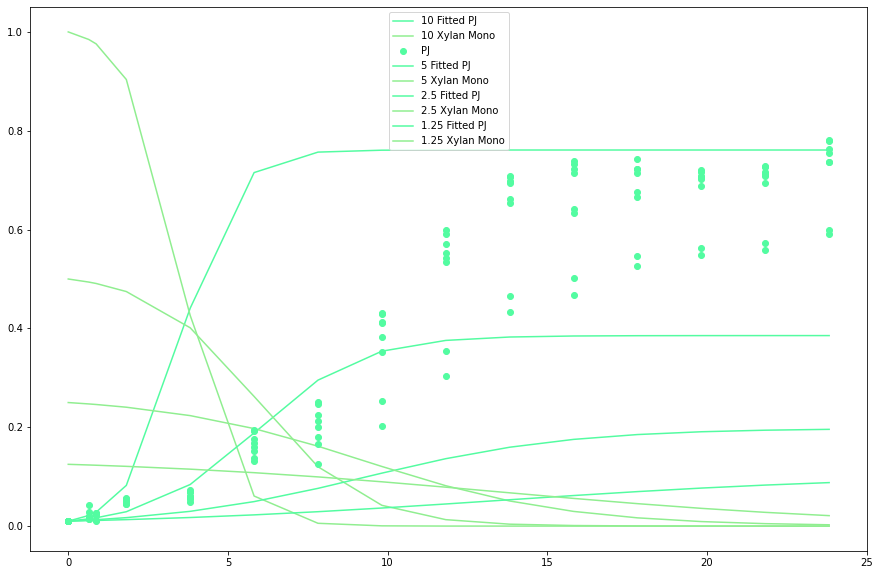

Parameters:  [1.12192213 1.16350749 0.        ]
RMSE:  0.07319887559775443


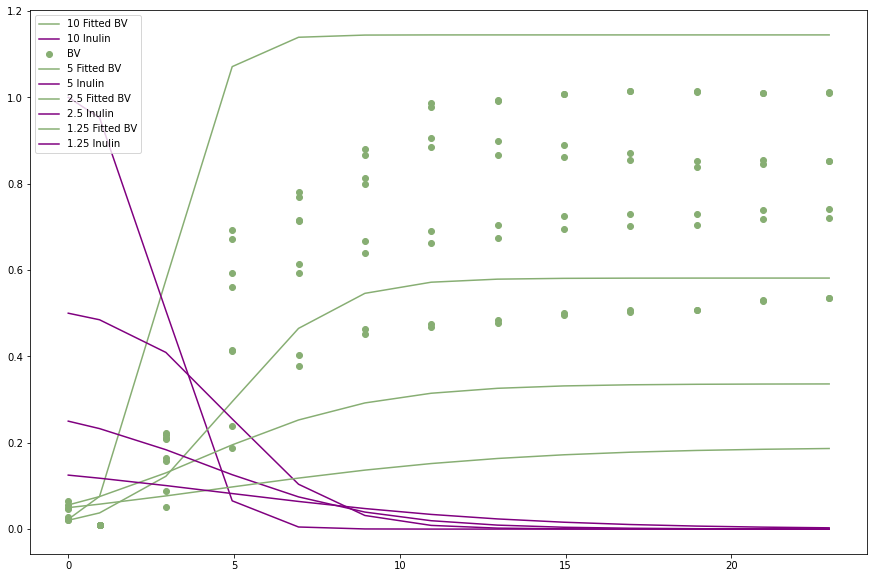

Parameters:  [1.22197516 1.01623052 0.        ]
RMSE:  0.08265729747536132


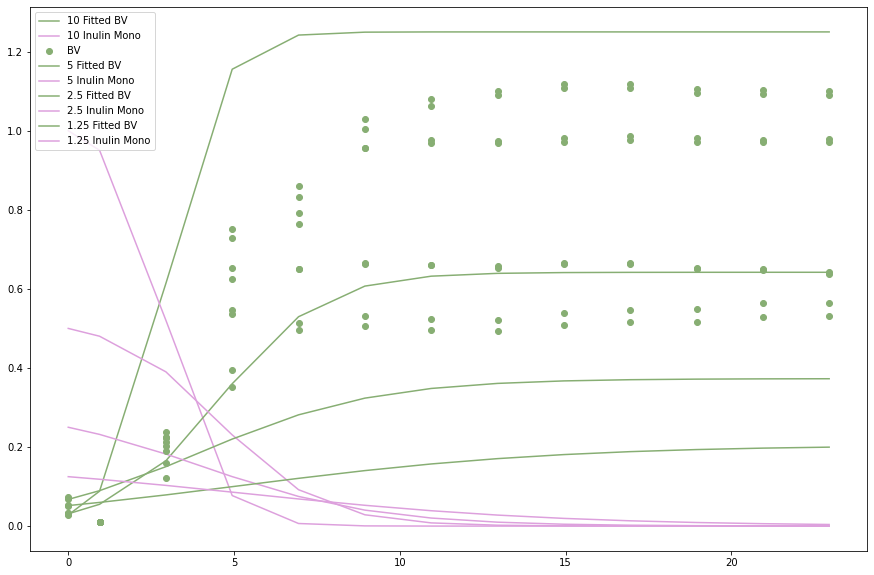

Parameters:  [0.19603133 0.37745077 0.01      ]
RMSE:  0.0013744244131936023


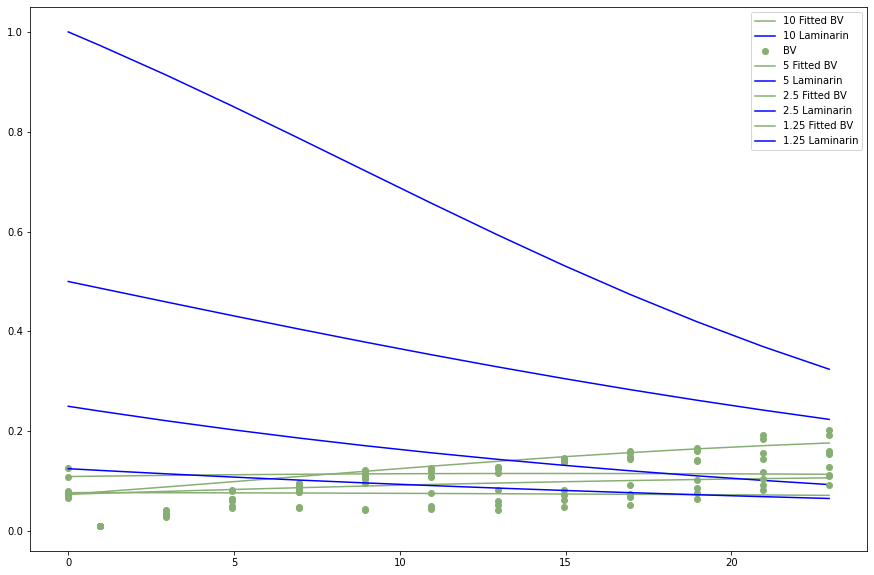

Parameters:  [1.20401077e+00 6.41618327e-01 2.68705746e-30]
RMSE:  0.08997938612017738


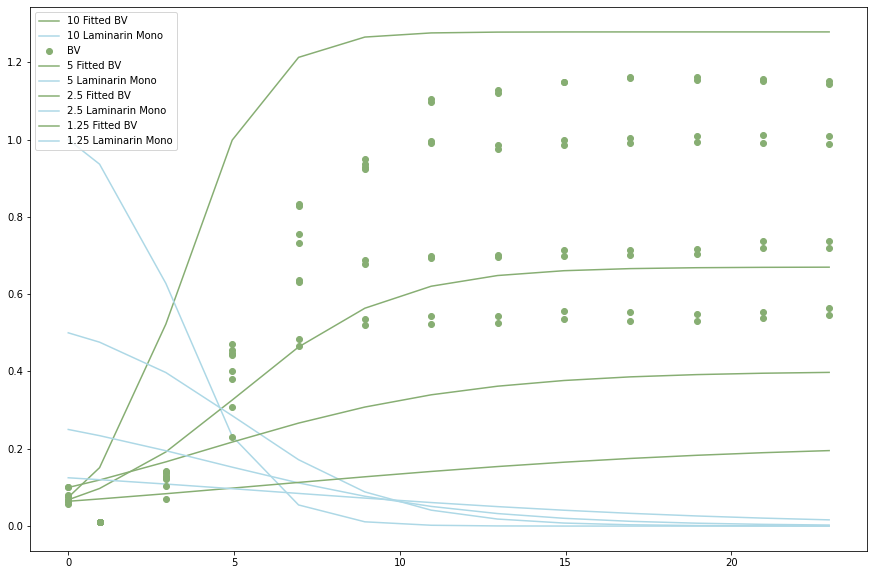

Parameters:  [0.13542473 0.33738305 0.01      ]
RMSE:  0.0021236241575580067


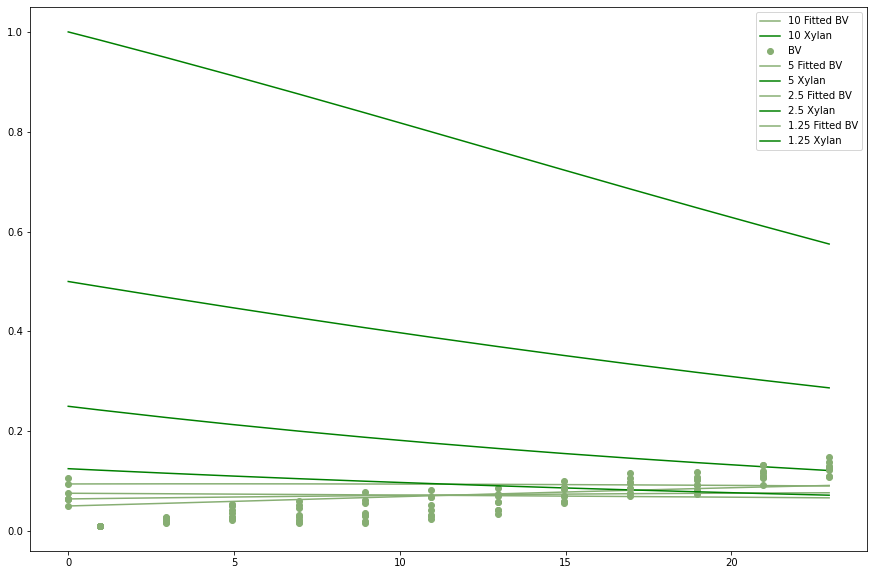

Parameters:  [1.19389569 1.1036114  0.        ]
RMSE:  0.0844007792576653


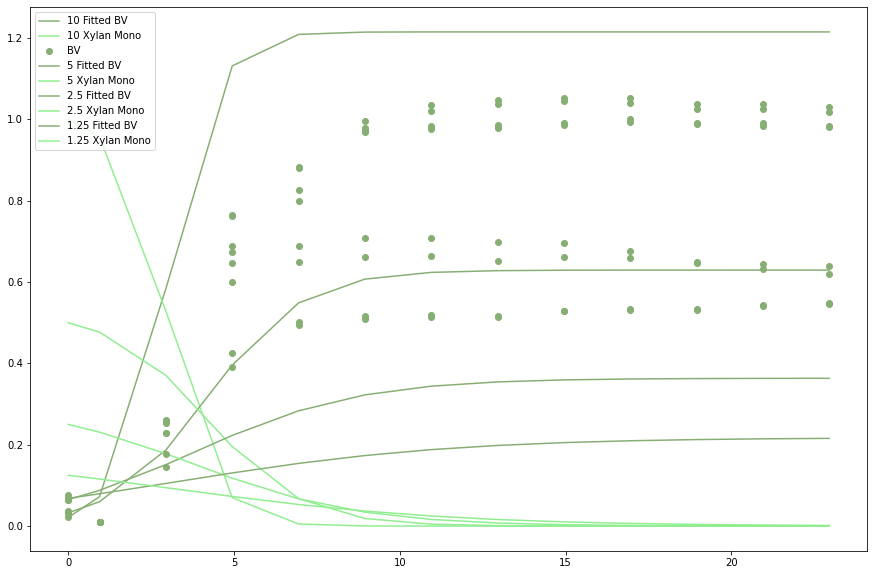

Parameters:  [0.69807199 1.25       0.01      ]
RMSE:  0.008567321080664384


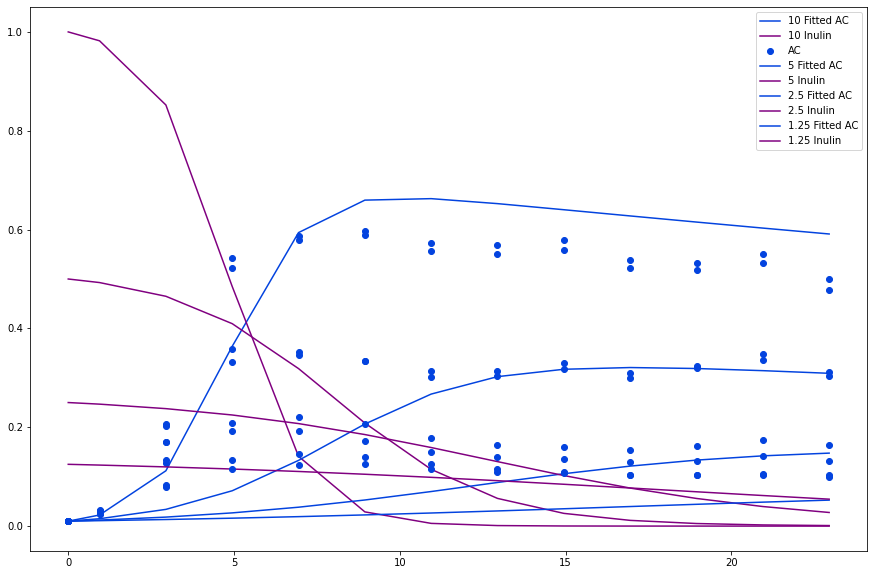

Parameters:  [1.33549728e+00 1.24833769e+00 8.65508154e-19]
RMSE:  0.06989310494894503


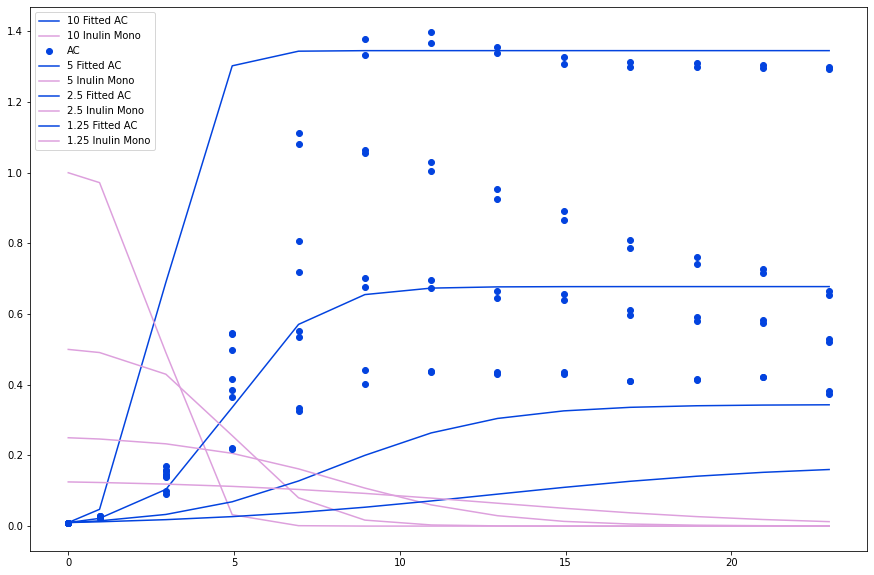

Parameters:  [0.1339636 0.2271002 0.01     ]
RMSE:  7.732021802552808e-06


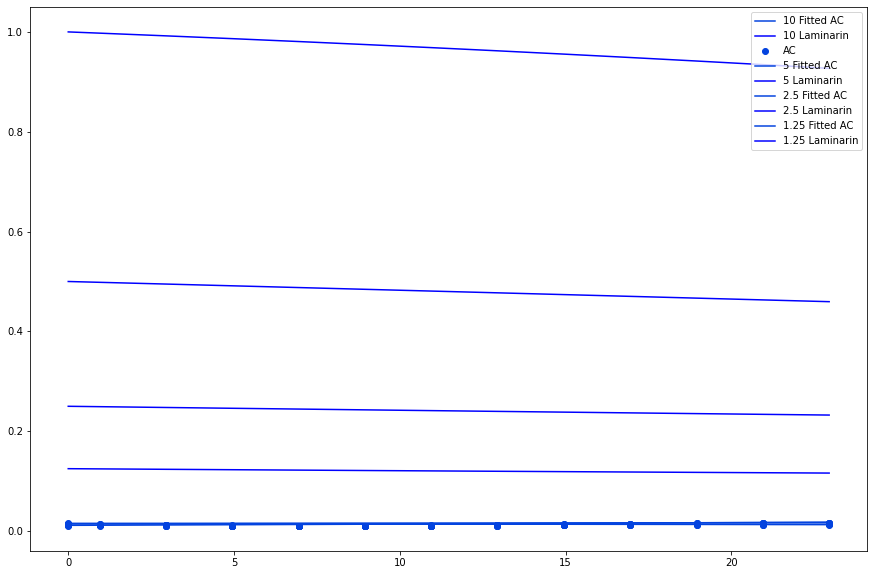

Parameters:  [0.29385643 1.75       0.01      ]
RMSE:  0.0033493528147207872


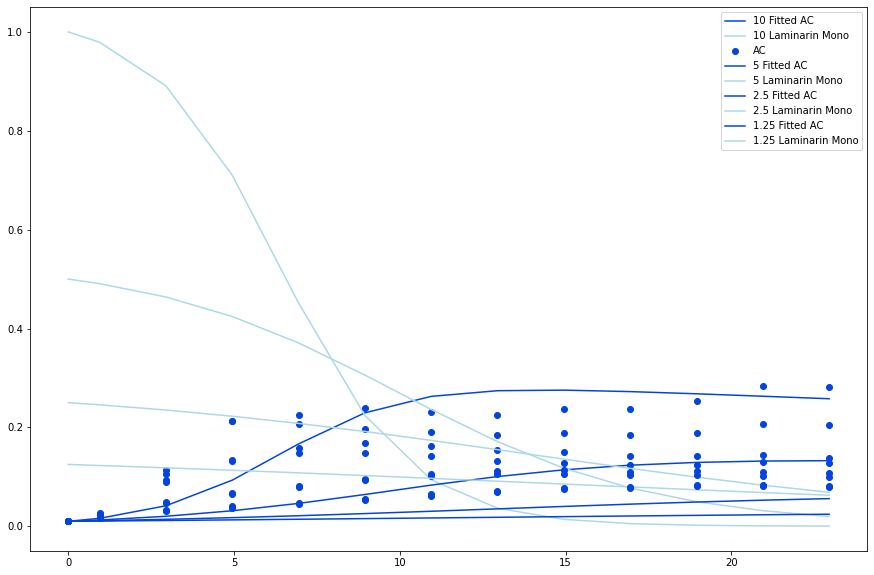

Parameters:  [2.87228385e-01 3.45437055e-01 3.65286046e-05]
RMSE:  2.064774134821143e-05


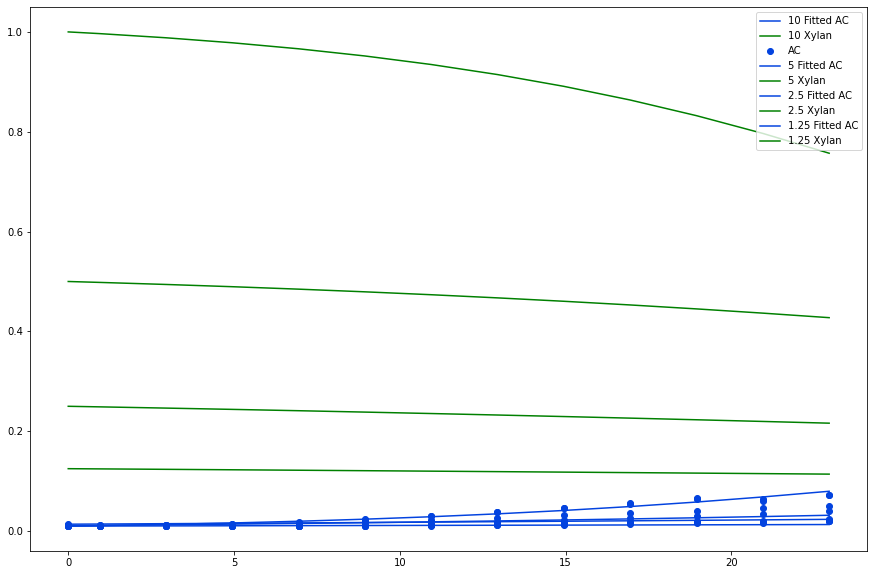

Parameters:  [1.28726672 1.31406083 0.        ]
RMSE:  0.06174353730572621


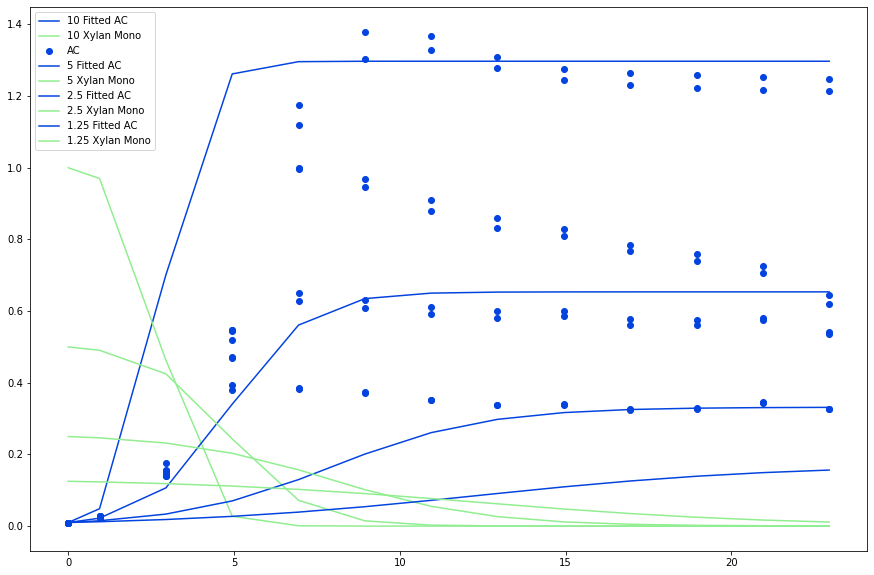

Parameters:  [0.34512575 0.3941586  0.        ]
RMSE:  0.0011339449072364659


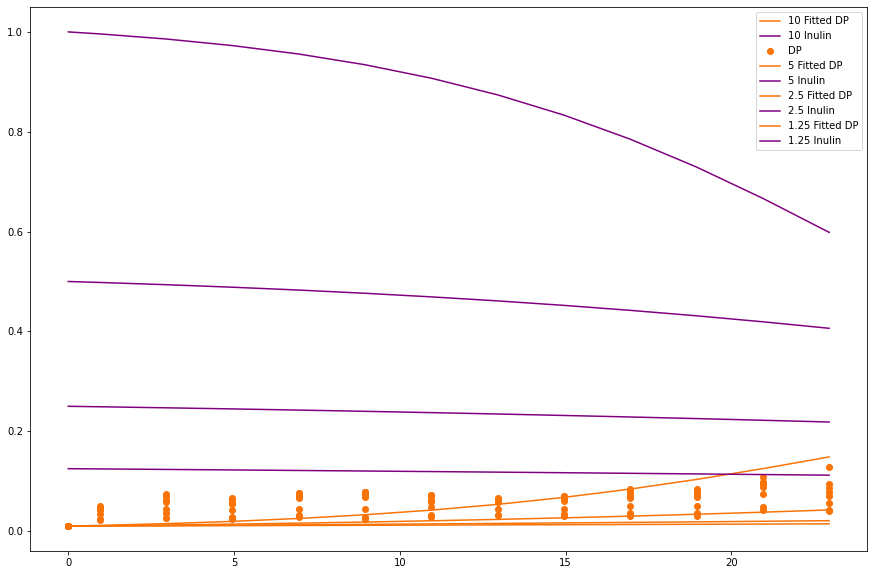

Parameters:  [0.34430049 0.39557032 0.        ]
RMSE:  0.0023413840815905544


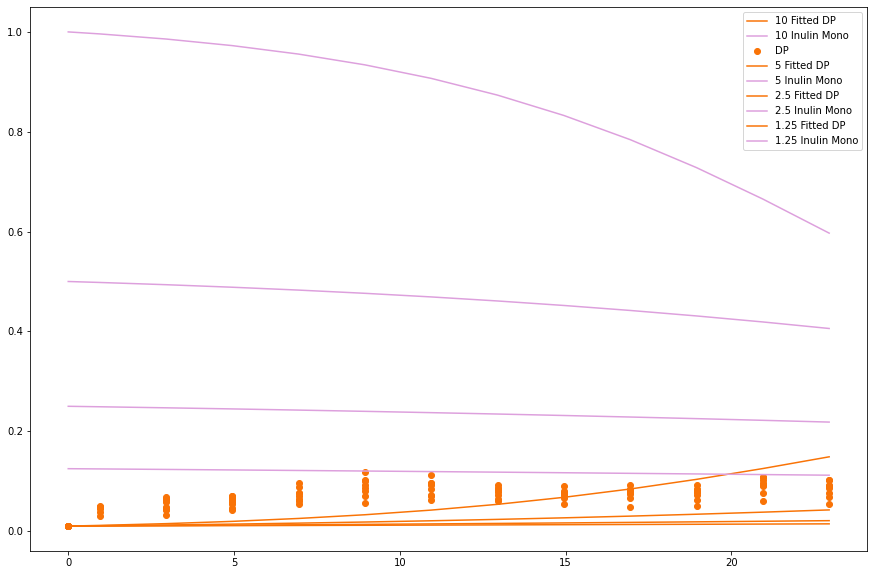

Parameters:  [3.74845123e-01 5.00000000e-01 7.49467781e-18]
RMSE:  0.004158043104663697


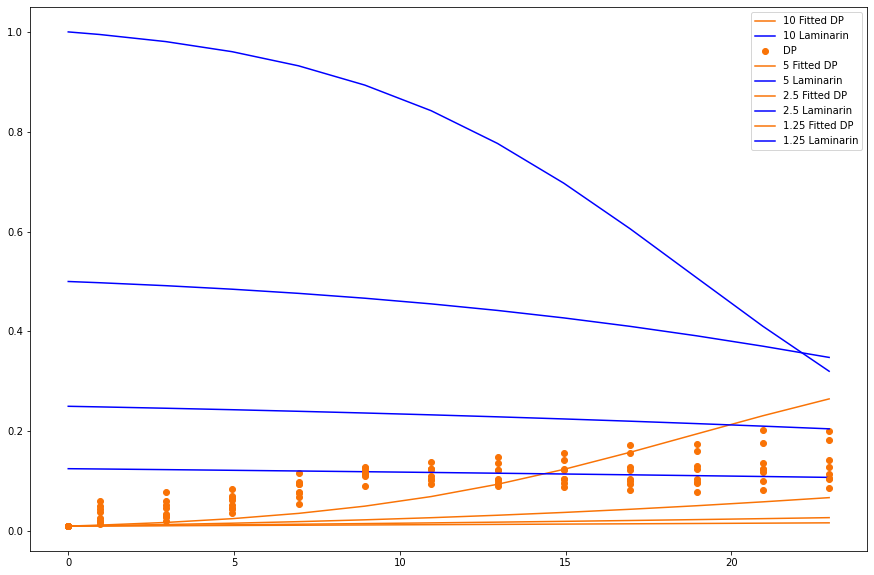

Parameters:  [3.24293702e-01 3.78547089e-01 8.52242134e-19]
RMSE:  0.0012598605231915088


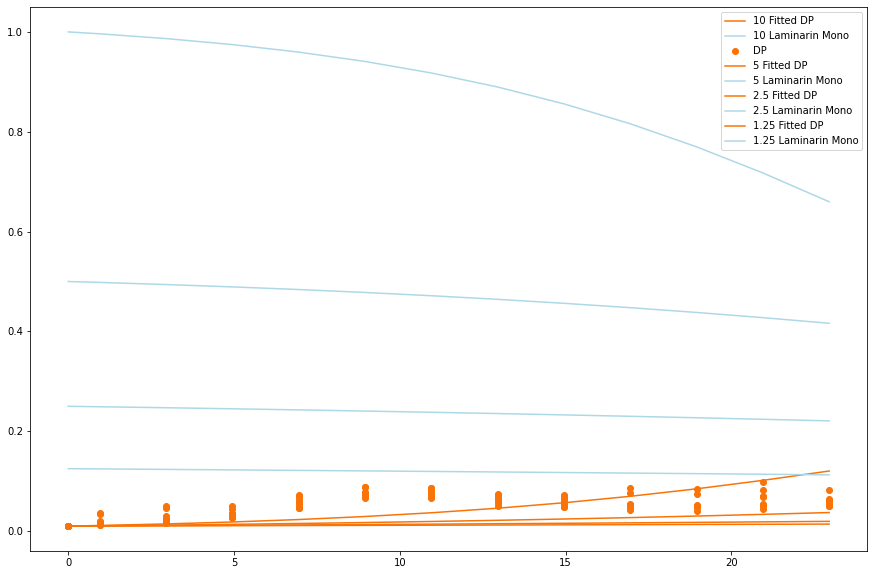

Parameters:  [0.41399709 0.5        0.        ]
RMSE:  0.00428916859126514


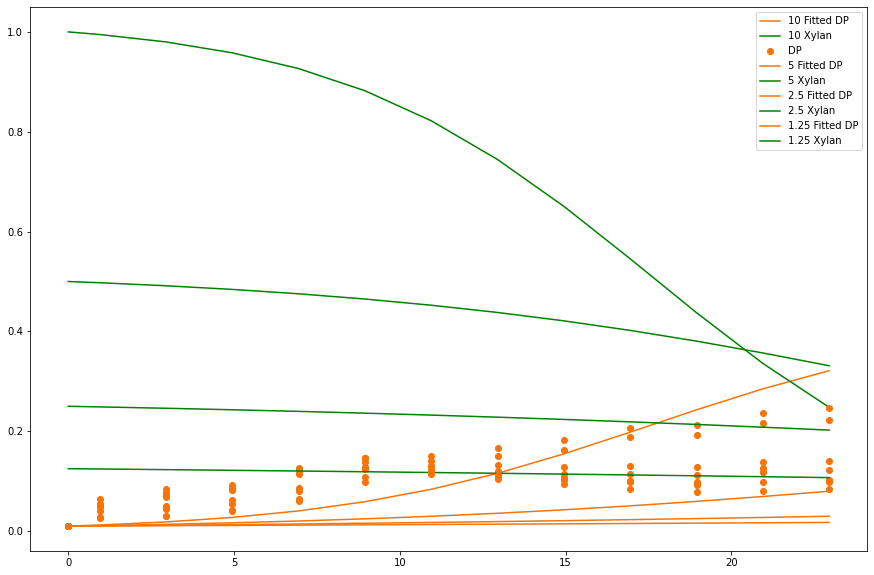

Parameters:  [3.45349121e-01 3.97255820e-01 1.71711317e-18]
RMSE:  0.003255635628374808


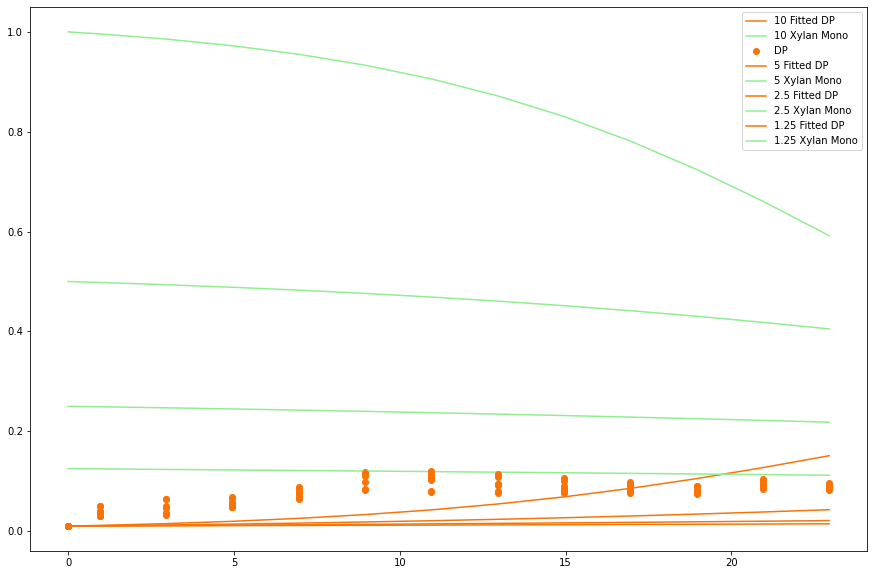

Parameters:  [0.79023895 1.25       0.        ]
RMSE:  0.018257992239258874


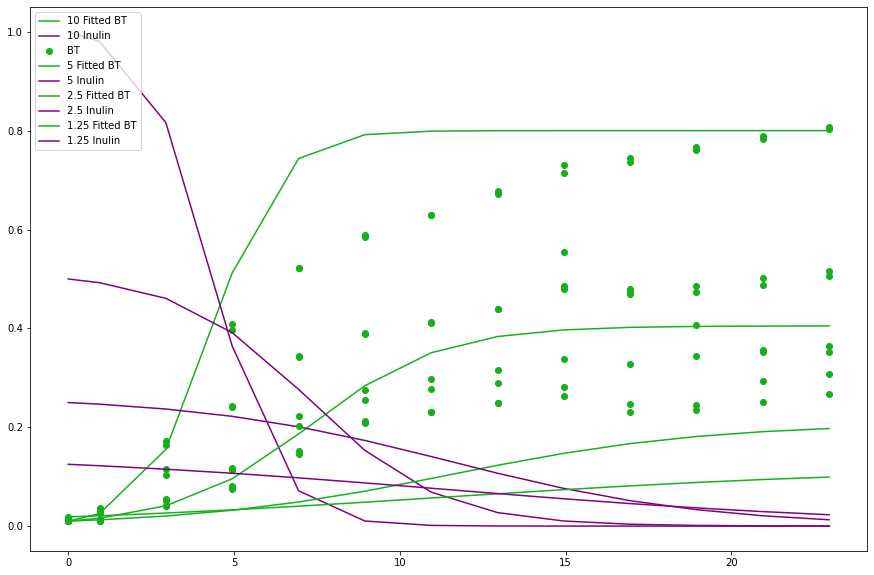

Parameters:  [1.1689725e+00 1.7500000e+00 6.9333478e-33]
RMSE:  0.11174552774264132


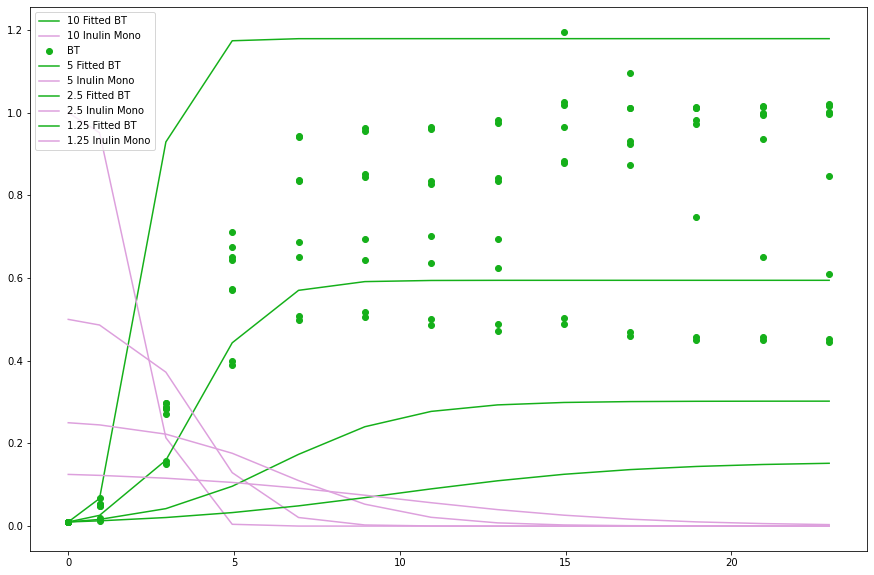

Parameters:  [0.36740936 0.5        0.        ]
RMSE:  0.006311470369350752


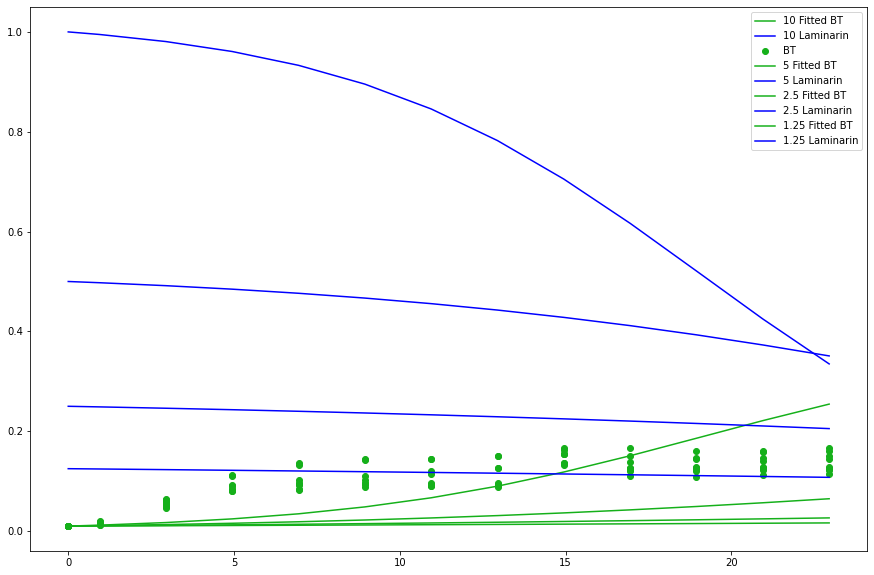

Parameters:  [1.09325773e+00 1.73619767e+00 3.01493277e-18]
RMSE:  0.11827890004829576


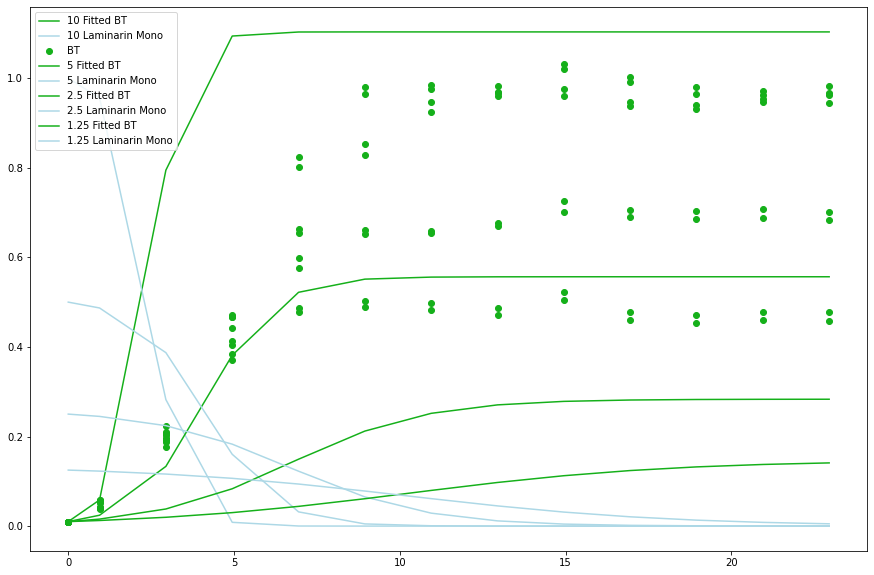

Parameters:  [3.78713584e-01 4.23219099e-01 1.06267650e-17]
RMSE:  0.00531349670823784


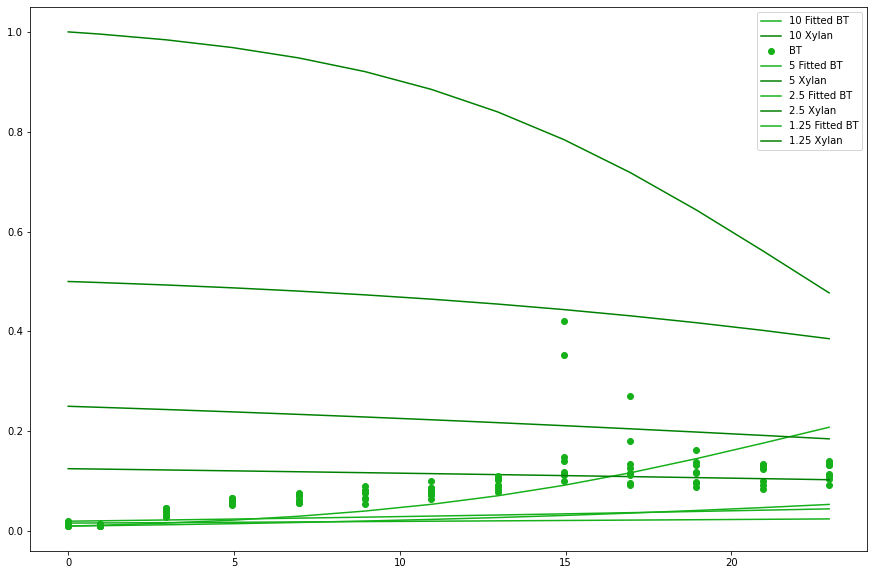

Parameters:  [1.13925160e+00 1.75000000e+00 1.99182169e-18]
RMSE:  0.10227422734604731


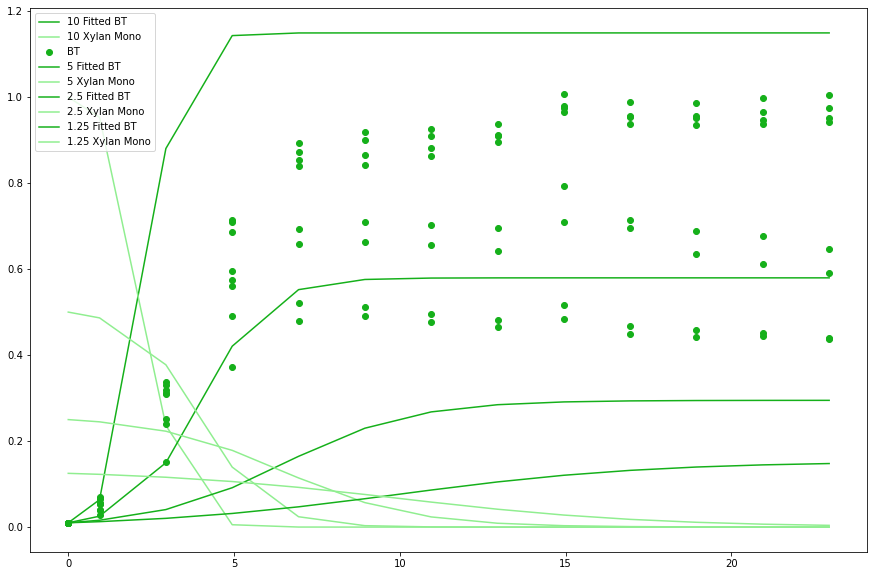

Parameters:  [1.01977439 1.25       0.        ]
RMSE:  0.08122621158040565


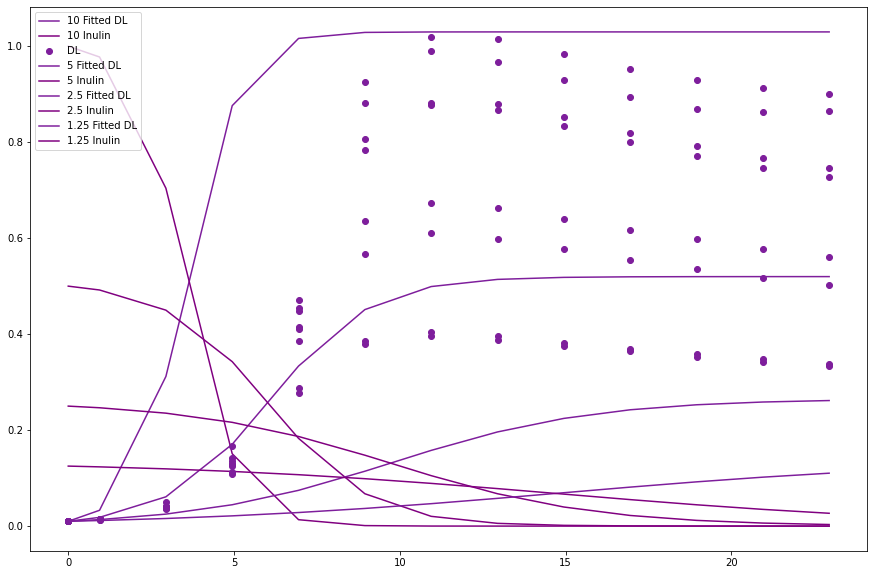

Parameters:  [1.01640082e+00 1.30842910e+00 1.20514367e-16]
RMSE:  0.10380074110253129


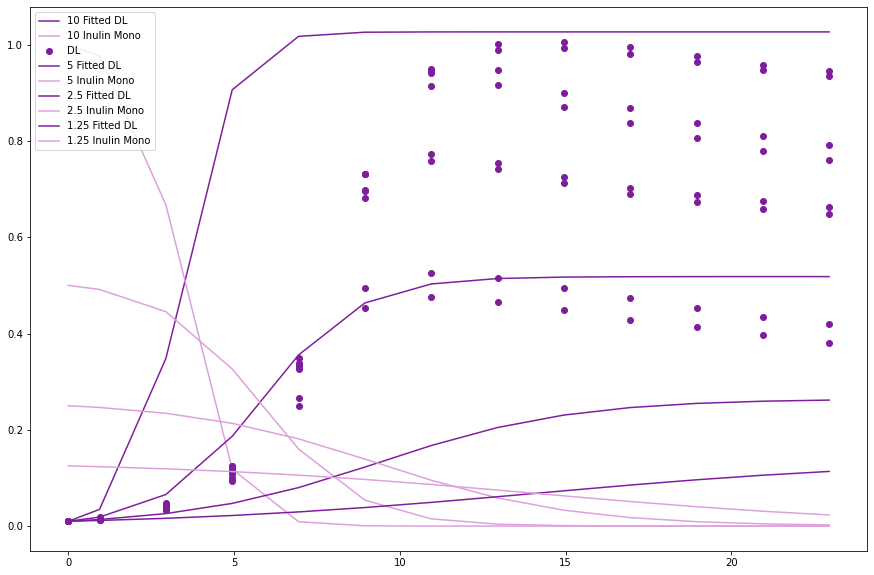

Parameters:  [0.35734279 0.5        0.        ]
RMSE:  0.006534971255791633


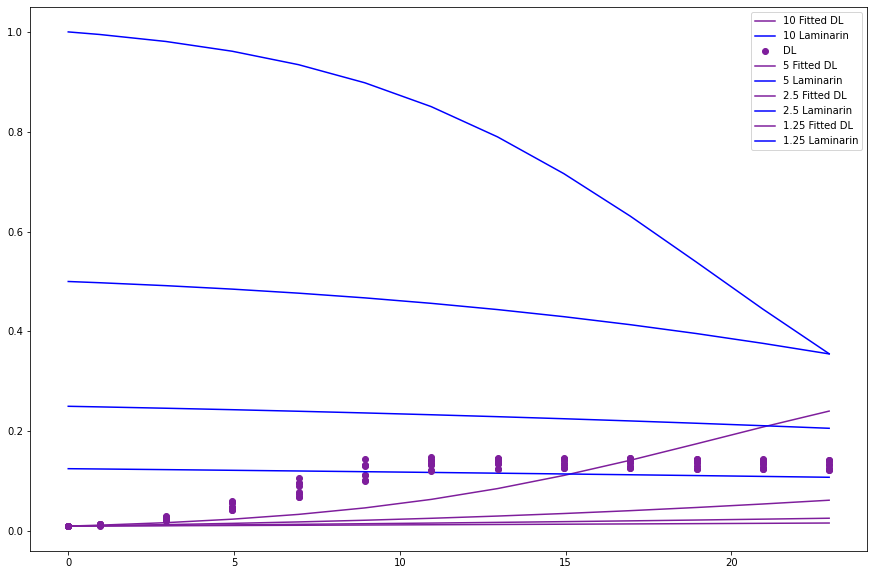

Parameters:  [1.00233185e+00 7.29327274e-01 5.63600213e-17]
RMSE:  0.02949565534535319


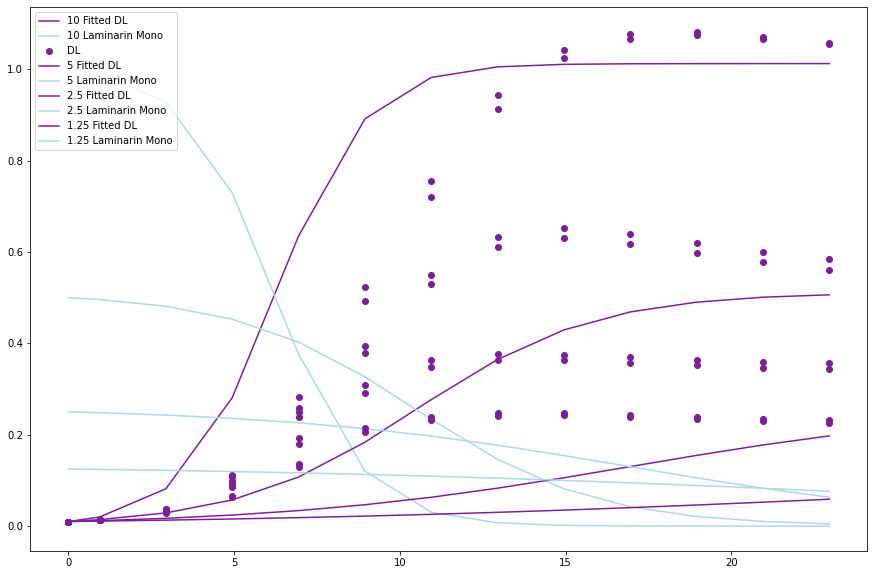

Parameters:  [0.36951747 0.5        0.        ]
RMSE:  0.006120758182696788


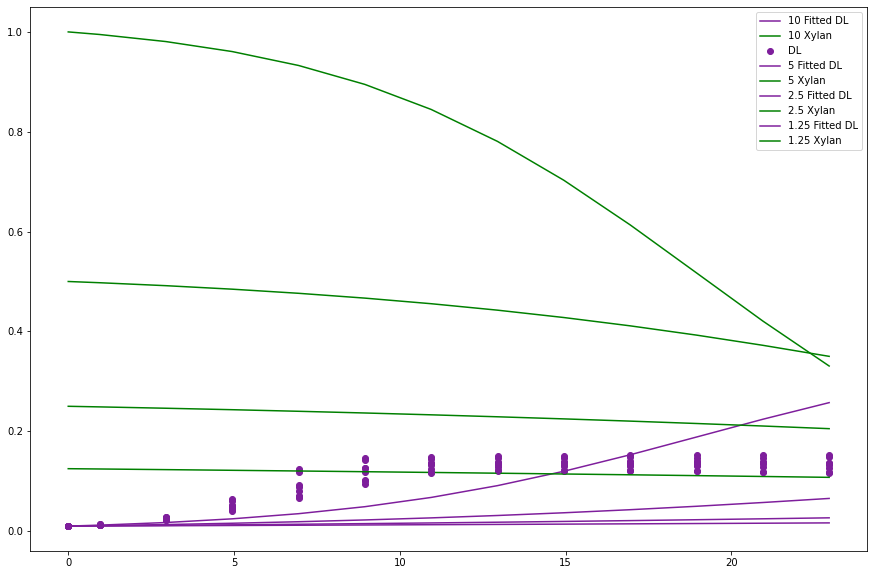

Parameters:  [1.3131026  0.77900936 0.        ]
RMSE:  0.11643113398893273


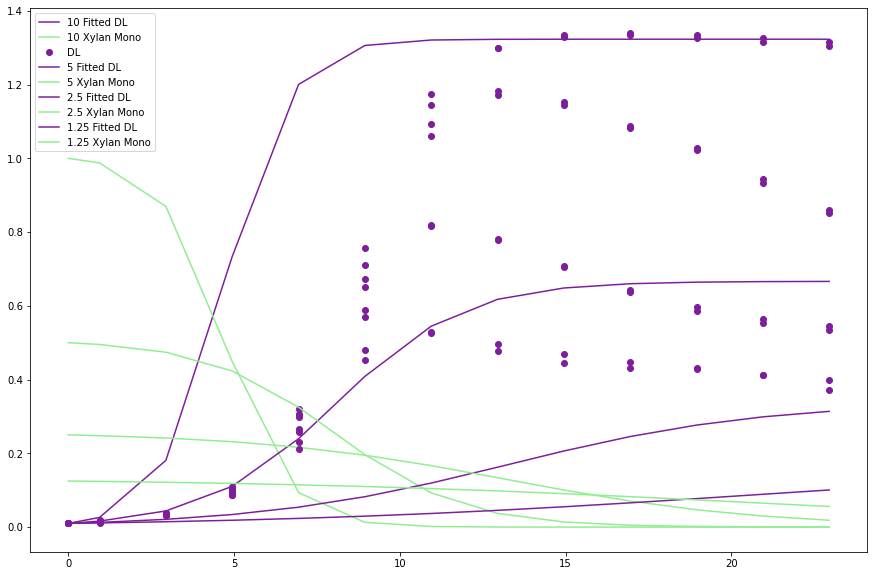

Parameters:  [1.25       0.12993843 0.        ]
RMSE:  0.00227344849342097


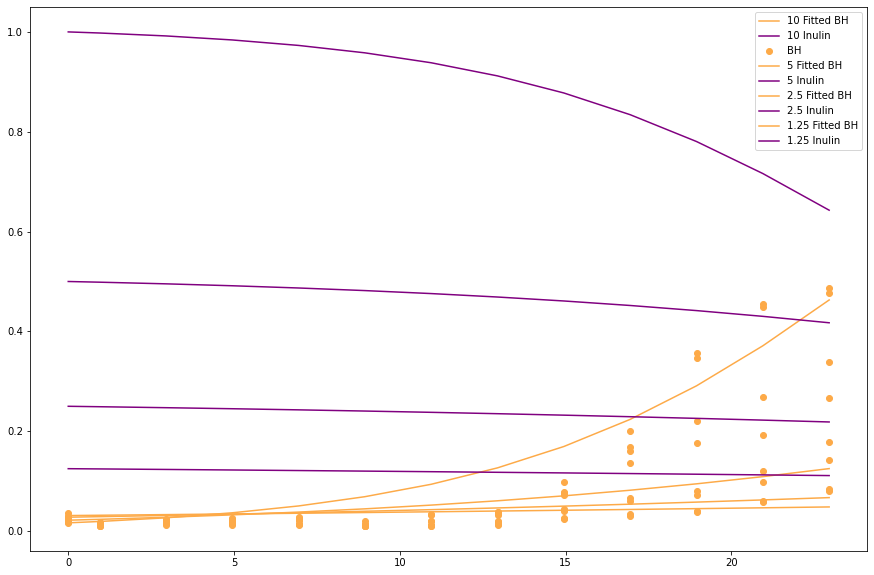

Parameters:  [1.57392592e+00 1.42446622e-01 2.28030105e-31]
RMSE:  0.07391312852086802


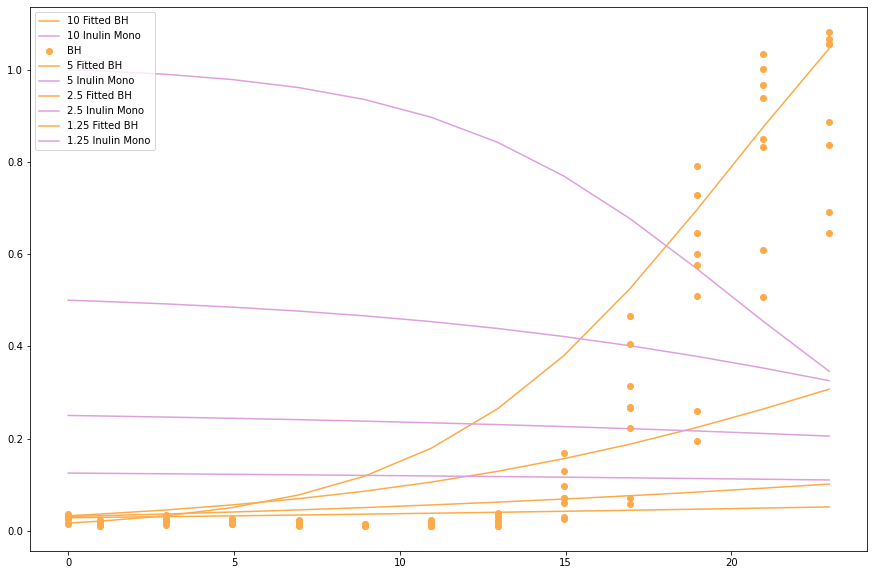

Parameters:  [0.19886762 0.28170381 0.        ]
RMSE:  0.0001035243582153151


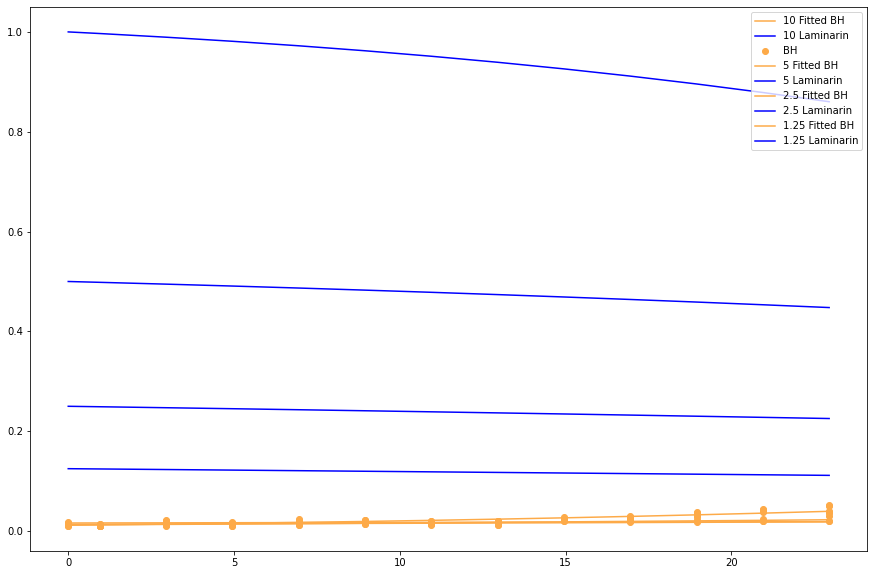

Parameters:  [0.1843994  0.26814264 0.        ]
RMSE:  9.295056659171557e-05


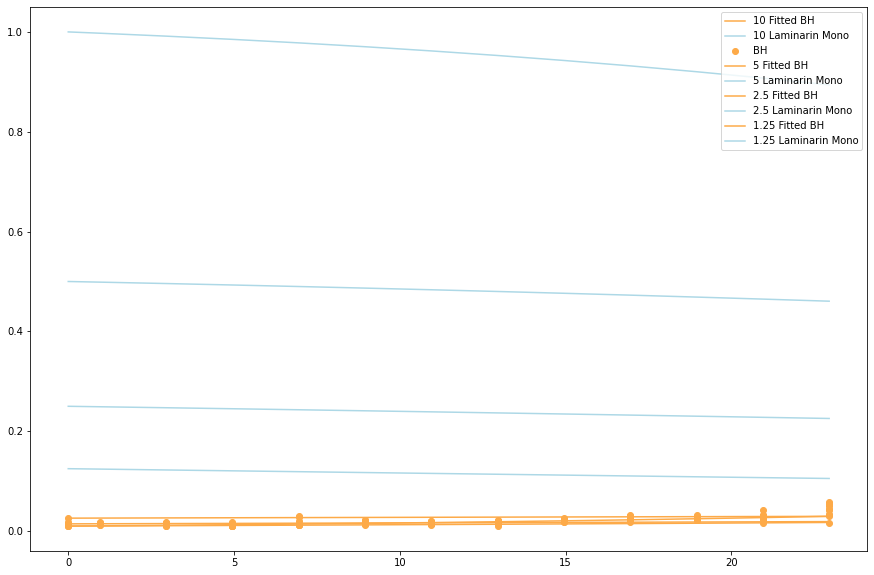

Parameters:  [0.19114369 0.27732583 0.01      ]
RMSE:  0.0001737423423783519


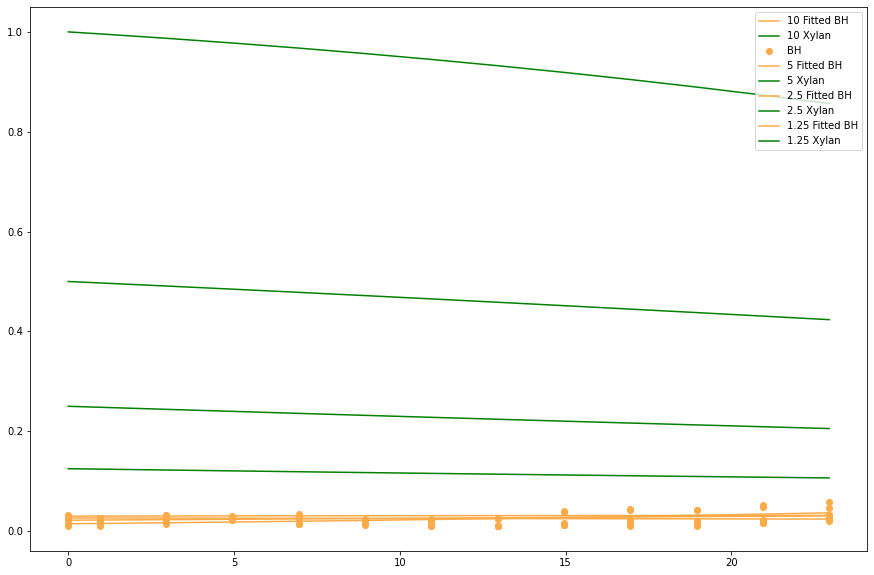

Parameters:  [1.74490013e+00 1.27512225e-01 2.50425195e-17]
RMSE:  0.07563771277495072


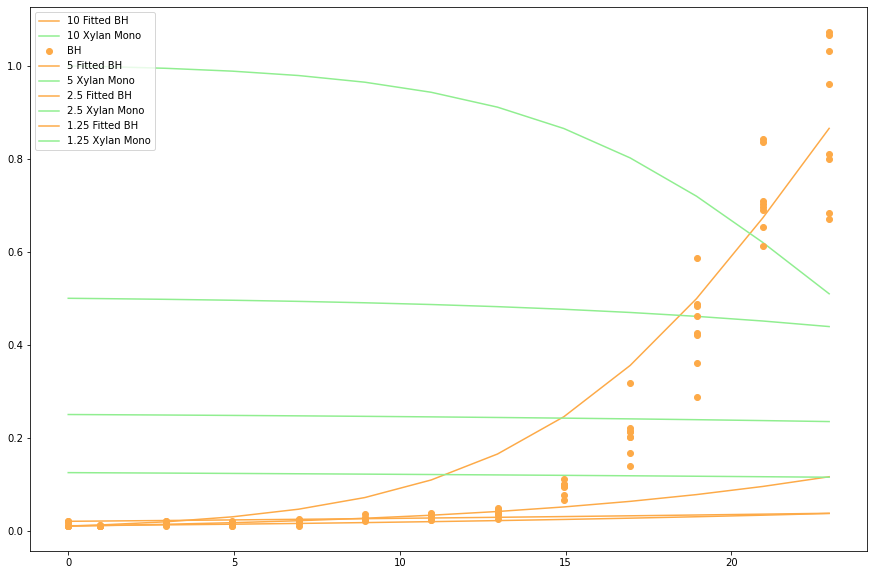

Parameters:  [0.53091224 0.73861944 0.        ]
RMSE:  0.005827769358749808


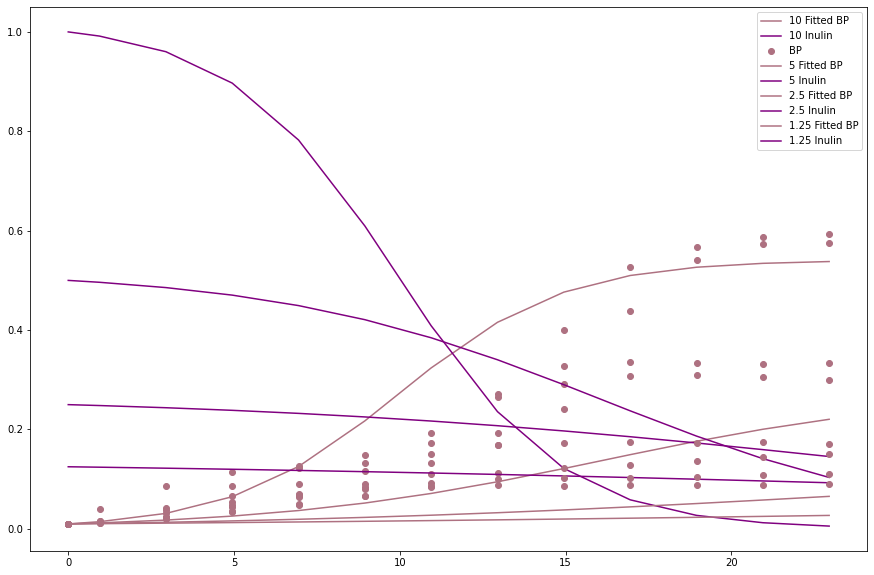

Parameters:  [0.6801215  0.54889864 0.        ]
RMSE:  0.0026414731627599727


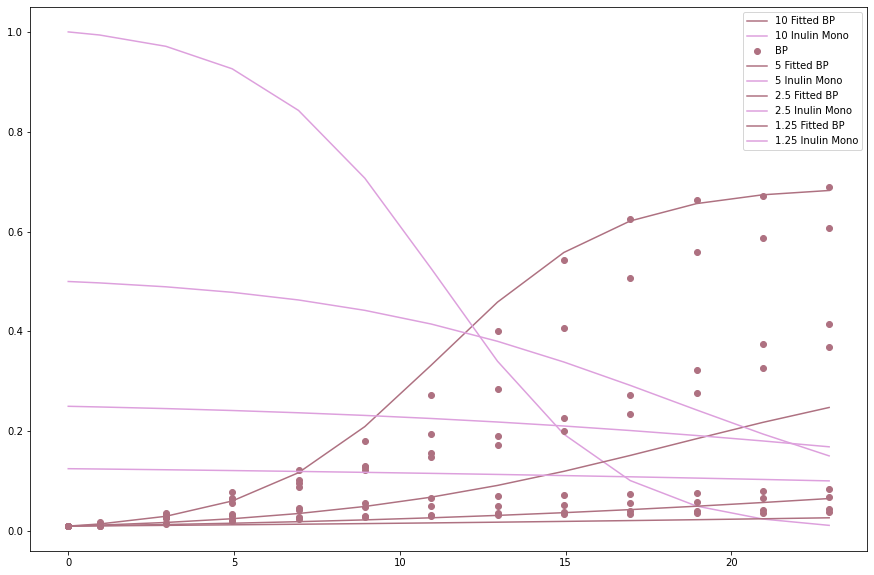

Parameters:  [0.08665322 0.23501333 0.        ]
RMSE:  0.00014634204760525005


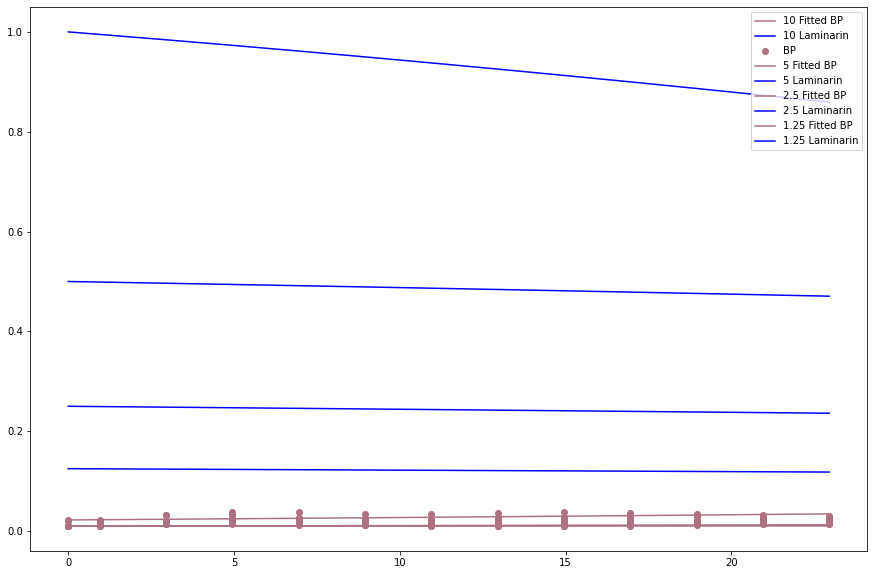

Parameters:  [0.27717111 1.65372214 0.        ]
RMSE:  0.0046019360463948585


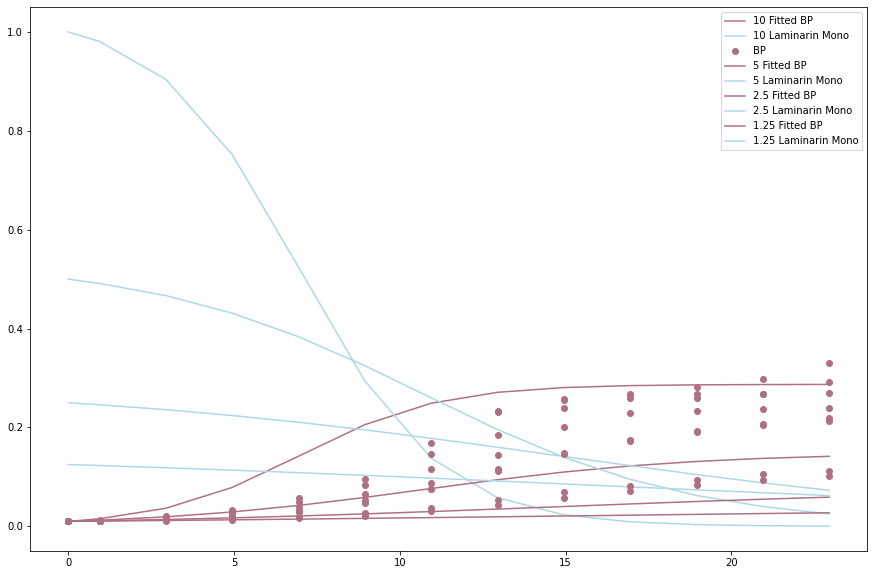

Parameters:  [0.24122822 0.3118642  0.00977646]
RMSE:  0.00011400081461090451


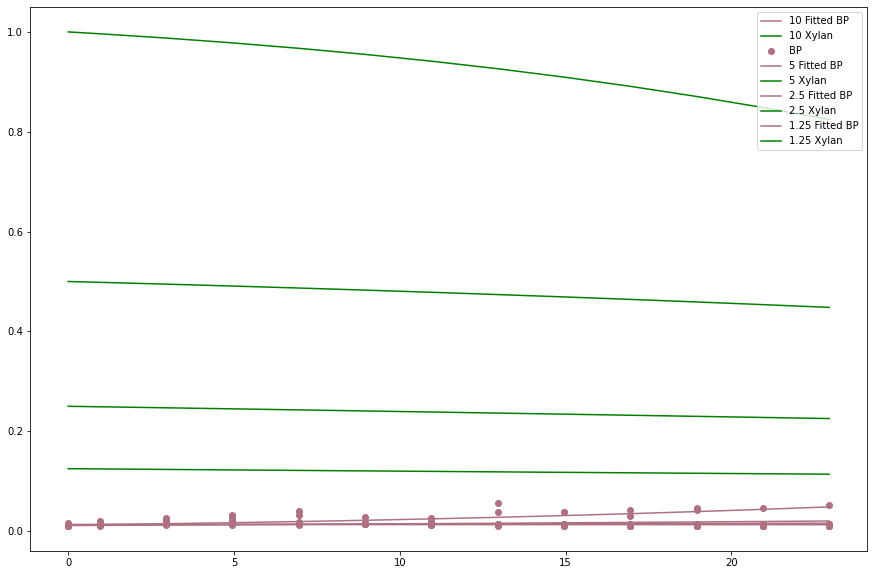

Parameters:  [0.57151187 0.60934839 0.        ]
RMSE:  0.00314417115820337


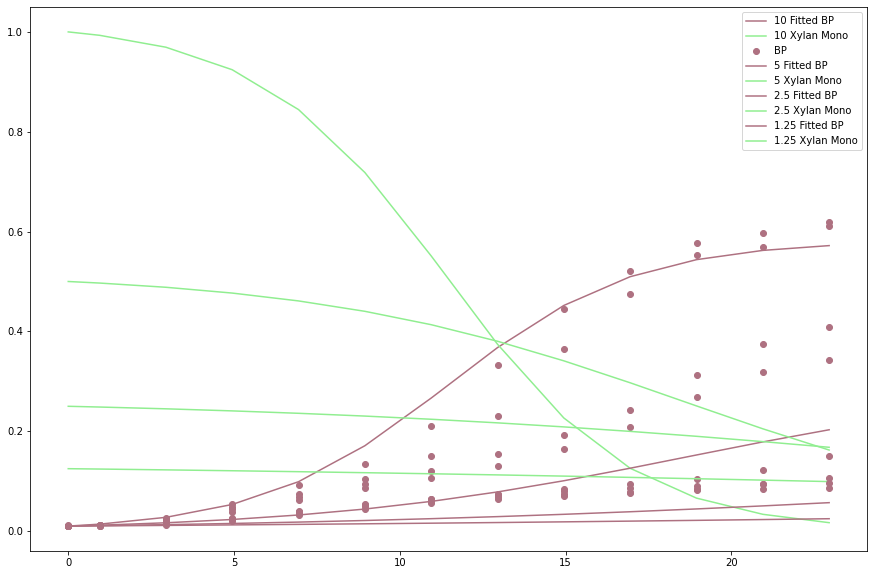

Parameters:  [0.35902968 0.41058949 0.        ]
RMSE:  0.0033483624572547967


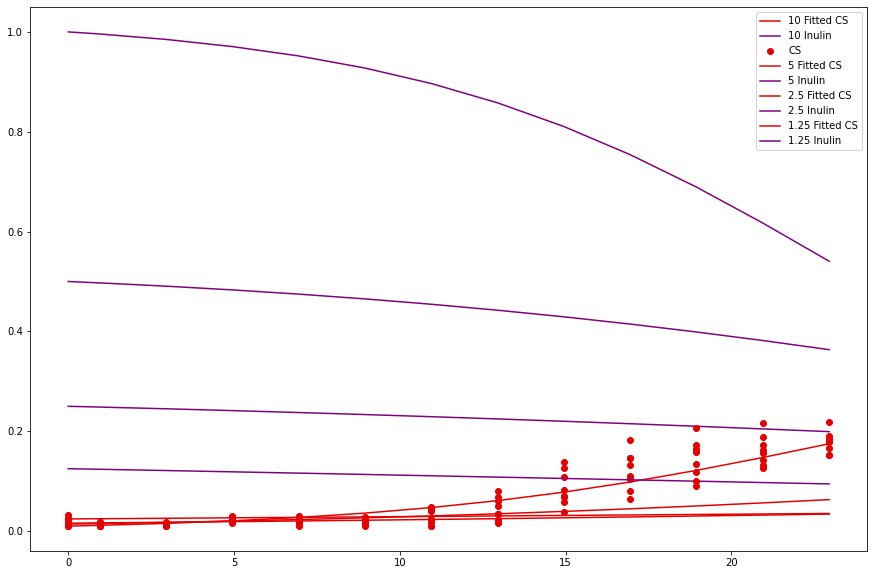

Parameters:  [6.97547292e-01 3.13166686e-01 3.98664217e-18]
RMSE:  0.009350235778236312


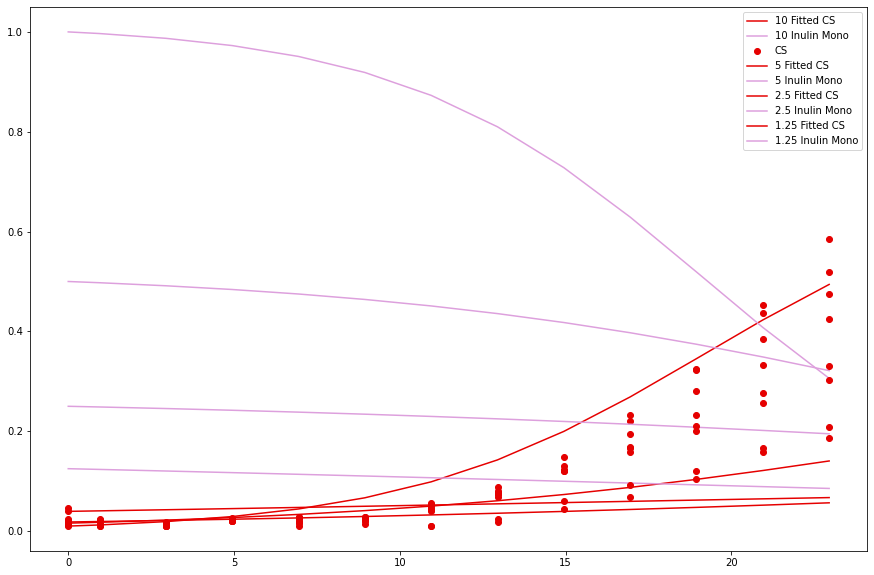

Parameters:  [0.36216256 0.40729223 0.        ]
RMSE:  0.0013836409508285023


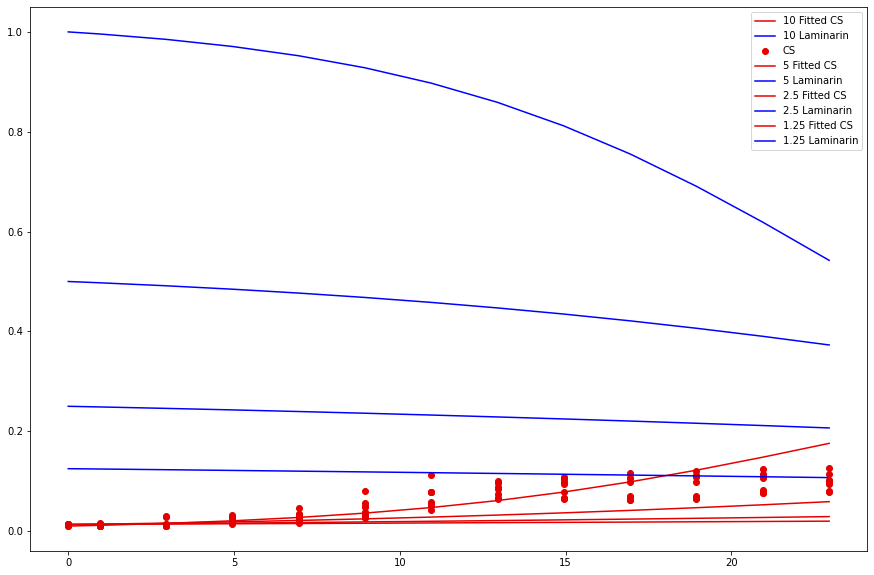

Parameters:  [0.38502715 0.42740416 0.        ]
RMSE:  0.004575143061316346


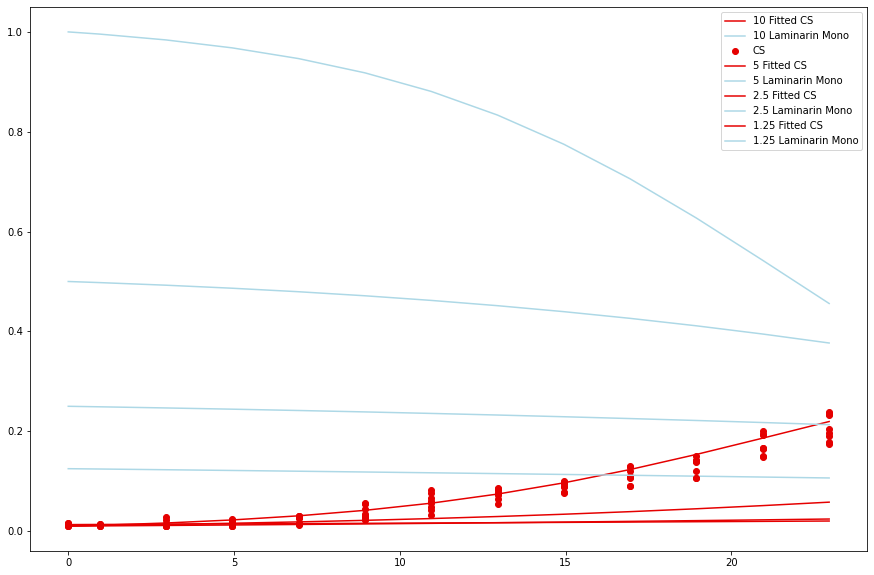

Parameters:  [3.51757330e-01 4.04323626e-01 1.70302864e-18]
RMSE:  0.0011063505645442775


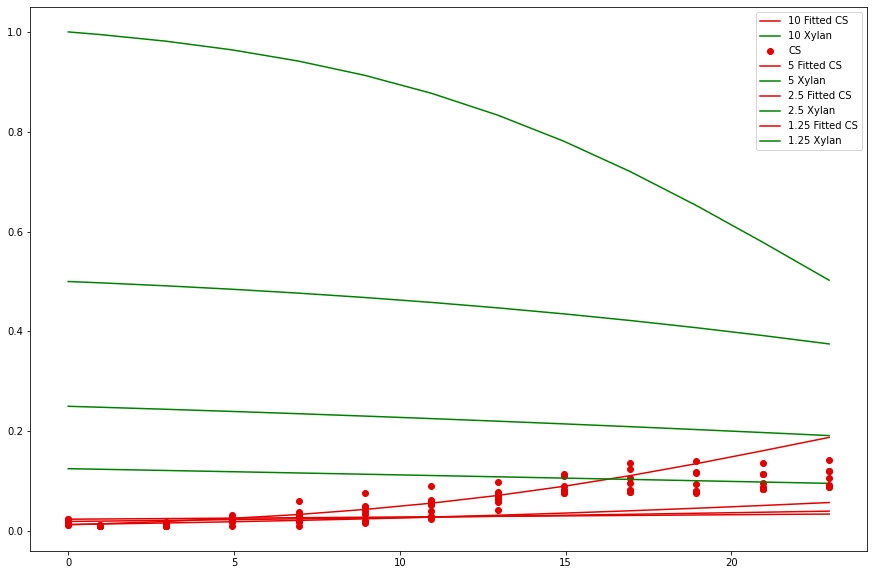

Parameters:  [3.99155929e-01 4.37141966e-01 7.44302661e-18]
RMSE:  0.004692221366455551


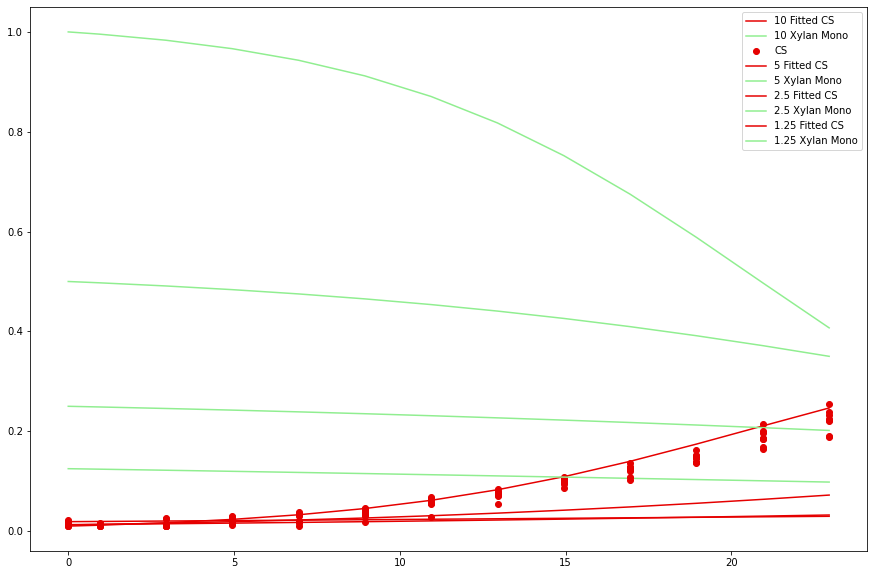

Parameters:  [0.30297169 0.36104955 0.        ]
RMSE:  0.00034109062402054417


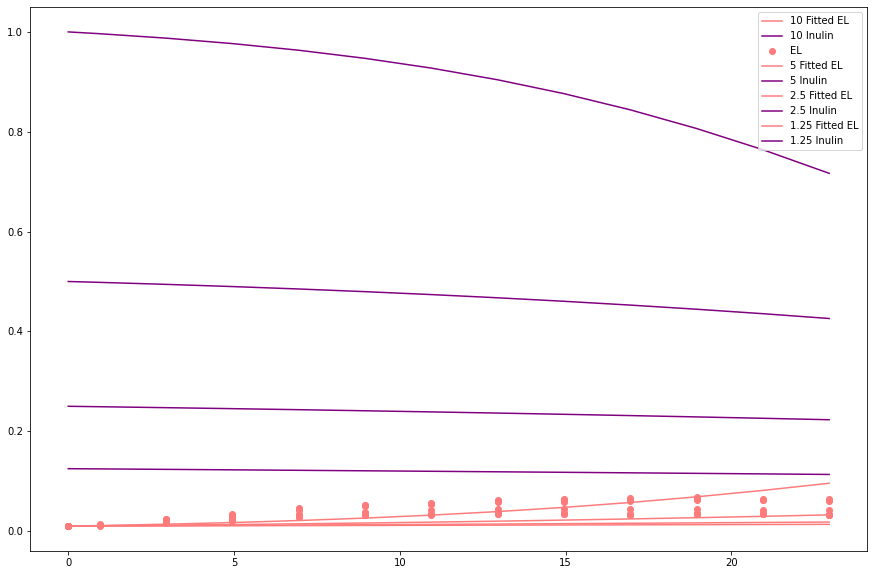

Parameters:  [0.28777779 0.34802461 0.        ]
RMSE:  0.00019445233258654618


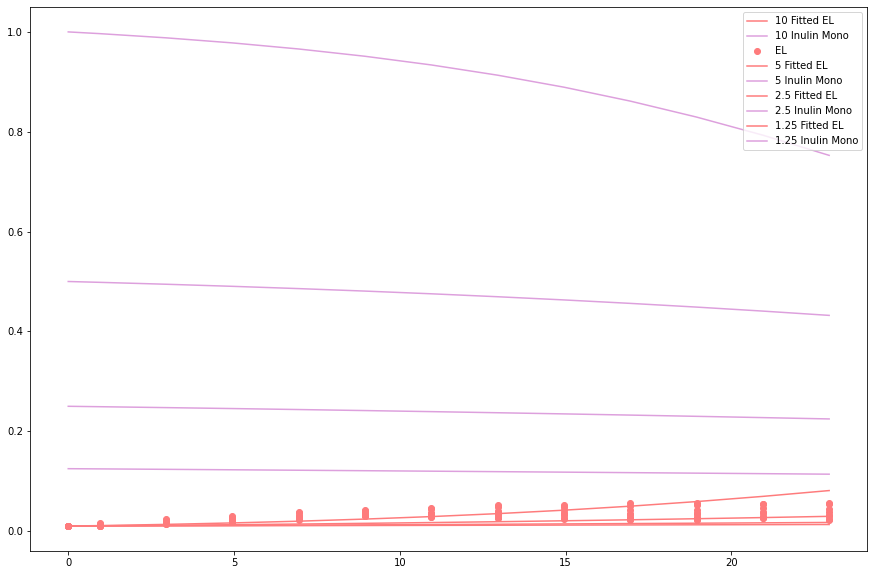

Parameters:  [2.44247925e-01 3.13567782e-01 4.22282867e-19]
RMSE:  0.000249911406372918


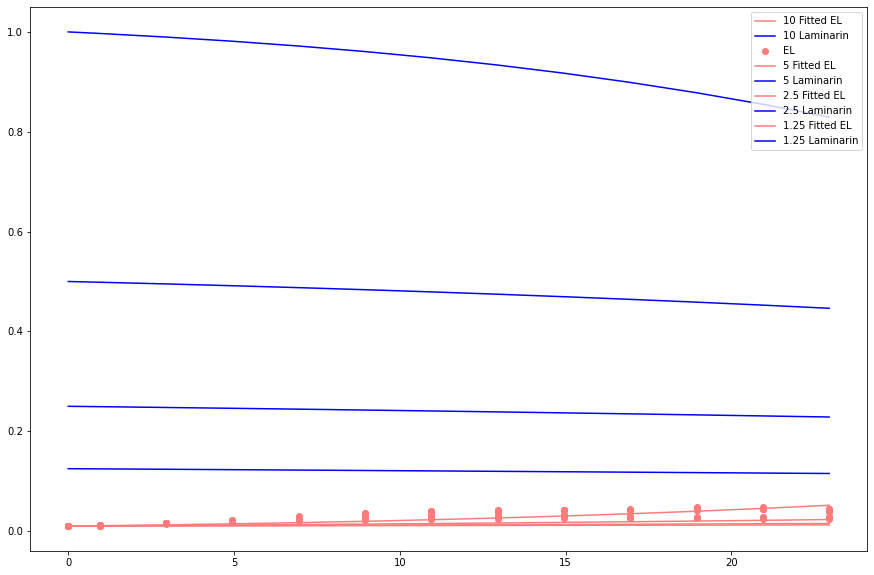

Parameters:  [2.50583741e-01 3.19439841e-01 4.21951716e-19]
RMSE:  0.00040083675937125404


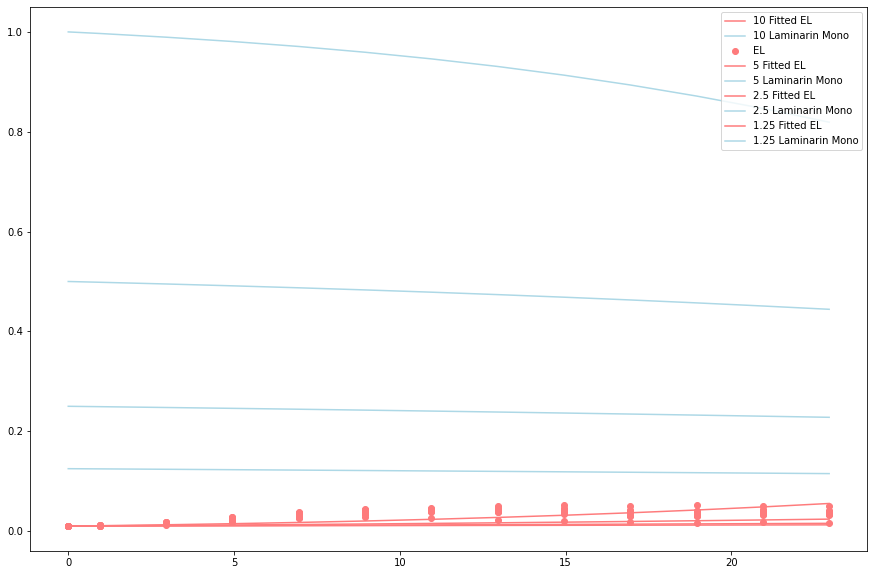

Parameters:  [3.49999860e-01 3.98002134e-01 8.60038952e-19]
RMSE:  0.0007004454531158815


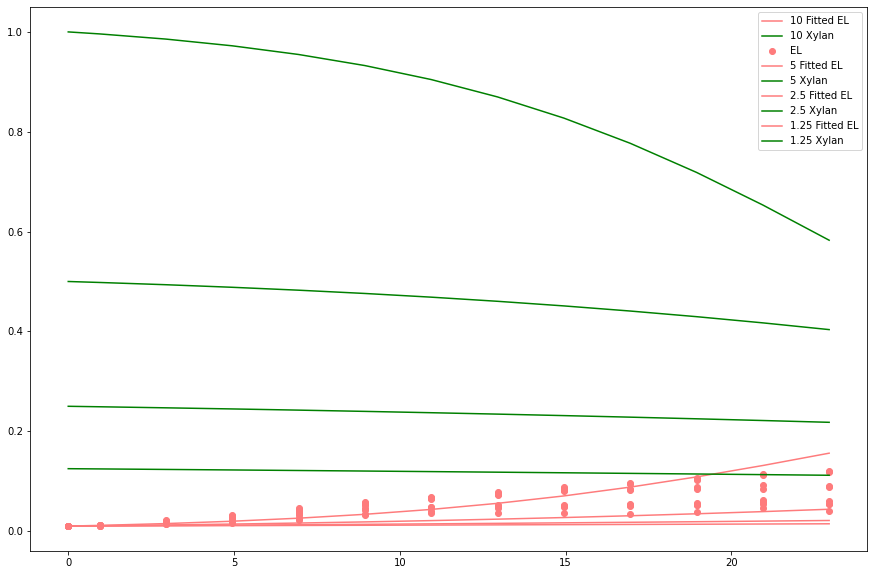

Parameters:  [2.29967729e-01 3.02774637e-01 8.43463876e-19]
RMSE:  0.00023442140182527182


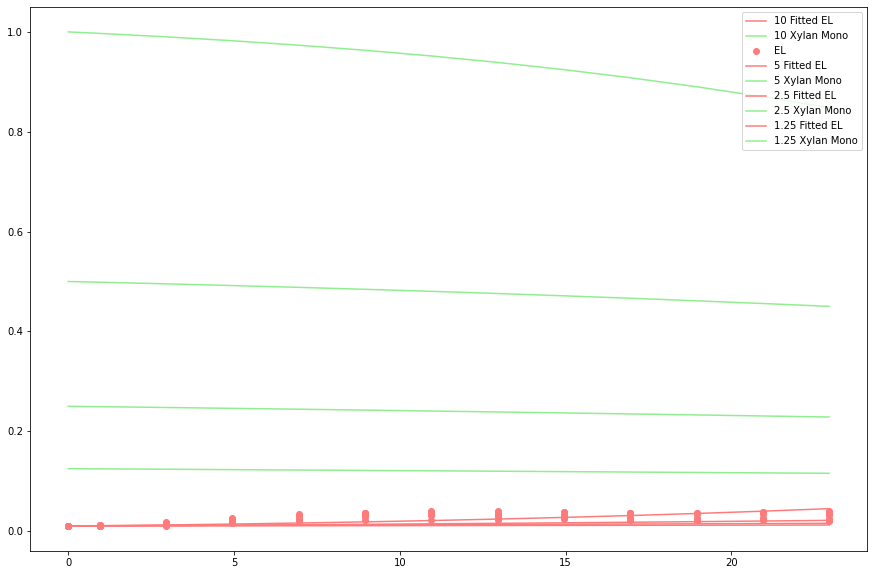

In [7]:
bounddict={
    'Inulin':1.25,
    'Inulin Mono':1.75,
    'Laminarin':0.5,
    'Laminarin Mono':1.75,
    'Xylan':0.5,
    'Xylan Mono':1.75
}
#initiate dataframe in which all species fits will be stored
MasterDF=pd.read_csv('/Users/Erin Ostrem/Documents/Venturelli_Lab/FiberEcology_Manuscript/MonospeciesGrowth.csv')
comm10species=['PJ','BV','AC','DP','BT','DL','BH','BP','CS','EL']
medialist=['Inulin','Inulin Mono','Xylan','Xylan Mono','Laminarin','Laminarin Mono']
MCRparams=pd.DataFrame()
indexz=0

base_med_conc = 0

for species in range(0,10):
    species1 = comm10species[species]
    for media in range(0,6):
#         frames=[]
#         for conc in [10.0,5.0,2.5,1.25]:

        data=MasterDF[(MasterDF['Species']==comm10species[species])&(MasterDF['Media']==medialist[media])]


        species1_m1_data=data.reset_index(drop=True)

        media1 = media_list[media]
    #         species1_m1_data = data[(data["Media"] == media1) & (data["Species"] == species1)] # Species 1 Media 1 data


        from scipy.integrate import odeint
        from scipy.optimize import minimize
        import matplotlib.pyplot as plt

        reg_par = 1*10**(-8)
        res = minimize(fun, [0.5, 0.5, 0.01], method = "SLSQP", 
                       args = (reg_par, species1_m1_data,media1), 
                       bounds = [[0, bounddict[media1]], [0, bounddict[media1]], [0, 0.01]])
        sol = res.x
        rmse_sol = get_error(sol[0], sol[1], sol[2], species1_m1_data,media1)
        print("Parameters: ", sol)
        print("RMSE: ", rmse_sol)

        # Plot data
        plot_tr_data(sol, species1_m1_data, media1, species1,base_med_conc)

        # Put parameters in a vector
        sp1_med1 = sol

        #add parameters to dataframe
        MCRparams.at[indexz,'Species']=species1
        MCRparams.at[indexz,'Media']=media1
        MCRparams.at[indexz,'W']=sol[0]
        MCRparams.at[indexz,'C']=sol[1]
        MCRparams.at[indexz,'M']=sol[2]
        MCRparams.at[indexz,'RMSE']=rmse_sol
#         MCRparams.at[indexz,'Base Media Conc']=basemedia
        indexz+=1

Inulin WC= 0.8799110472272171
Inulin Mono WC= 1.0832287661287312
Laminarin WC= 0.28674105335084094
Laminarin Mono WC= 0.89432205546495
Xylan WC= 0.3355813142497487
Xylan Mono WC= 1.1487535478415465


(0.0, 10.0)

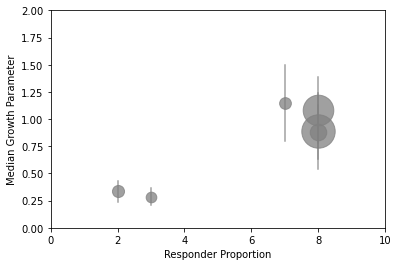

In [8]:
distDF=pd.read_csv('/Users/Erin Ostrem/Documents/Venturelli_Lab/3.16.2020_initial_abundance/distance_between_comms.csv')
sputDict={
    'Inulin':['AC','DL','BT','BV','BP','BH','PJ'],
    'Inulin Mono':['AC','DL','BT','BV','BP','CS','BH','PJ'],
    'Laminarin':['PJ','BT','DL'],
    'Laminarin Mono': ['AC','DL','BT','BV','BP','BH','PJ'],
    'Xylan':['BV','BT'],
    'Xylan Mono':['AC','DL','BT','BV','BP','PJ']
}

utspecies={'Laminarin Mono': ['PJ', 'BV', 'AC', 'BT', 'DL', 'BH', 'BP', 'CS'],
 'Inulin Mono': ['PJ', 'BV', 'AC', 'BT', 'DL', 'BH', 'BP', 'CS'],
 'Inulin': ['PJ', 'BV', 'AC', 'BT', 'DL', 'BH', 'BP', 'CS'],
 'Xylan Mono': ['PJ', 'BV', 'AC', 'BT', 'DL', 'BP', 'CS'],
 'Laminarin': ['PJ', 'BV', 'AC'],
 'Xylan': ['BV', 'DL'],
 'No carb': []}


for z in list(MCRparams.index.values):
    w=MCRparams.at[z,'W']
    c=MCRparams.at[z,'C']
    MCRparams.at[z,'WC']=(w+c)/2
medialist = ['Inulin','Inulin Mono', 'Laminarin','Laminarin Mono' ,'Xylan','Xylan Mono']
numuts={
    'Laminarin Mono':8,
    'Inulin Mono':8,
    'Inulin':8,
    'Xylan Mono':7,
    'Laminarin':3,
    'Xylan':2
}

thingDF=pd.DataFrame()
x=[]
y=[]
ystds=[]
sizes=[]

for media in medialist:
    subDF=MCRparams[(MCRparams['Media']==media)&(MCRparams.Species.isin(utspecies[media]))]
    tempDF=distDF[(distDF['Media']==media)]
    allsizes=list(tempDF['Euclidean Distance'])

    params=np.median(subDF['WC'])
    std=np.std(subDF['WC'])
    x.append(numuts[media])
    y.append(params)
    sizes.append(np.median(allsizes))
    ystds.append(std)
    print(media+' WC= '+str(params))
    
for i in range(len(x)):
    plt.plot(x[i],y[i],marker='o',color='gray',markersize=sizes[i]*100,alpha=0.75)
    plt.plot([x[i],x[i]],[y[i]-ystds[i],y[i]+ystds[i]],marker=None,color='gray',alpha=0.75)
plt.xlabel('Responder Proportion')
plt.ylabel('Median Growth Parameter')
plt.ylim(0,2)
plt.xlim(0,10)